 
    
<hr>
    
<font color='dodgerblue'>**A few words about the project:**</font> thank you very much for sending the project for a review! You have successfully employed advanced techniques such as lemmatization and vectorizing, and trained several models. Great job! The results look very good. 
     


</div>

# Sentiment Analysis of Film Reviews: Building a Machine Learning Model to Detect Negative Feedback

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [3]:
import math
import sklearn.metrics as metrics

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [5]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [6]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [7]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [8]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [9]:
df_reviews['average_rating'].fillna(df_reviews['average_rating'].mean(), inplace=True)
df_reviews['votes'].fillna(df_reviews['votes'].median(), inplace=True)

In [10]:
df_reviews.duplicated().sum()

0

Now our data is cleaned and ready for EDA. All column titles are lower case and appropriately formatted, we've filled in missing values with the mean value of the corresponding column, and we've confirmed that there are no duplicate entries. 

## EDA

Let's check the number of movies and reviews over years.

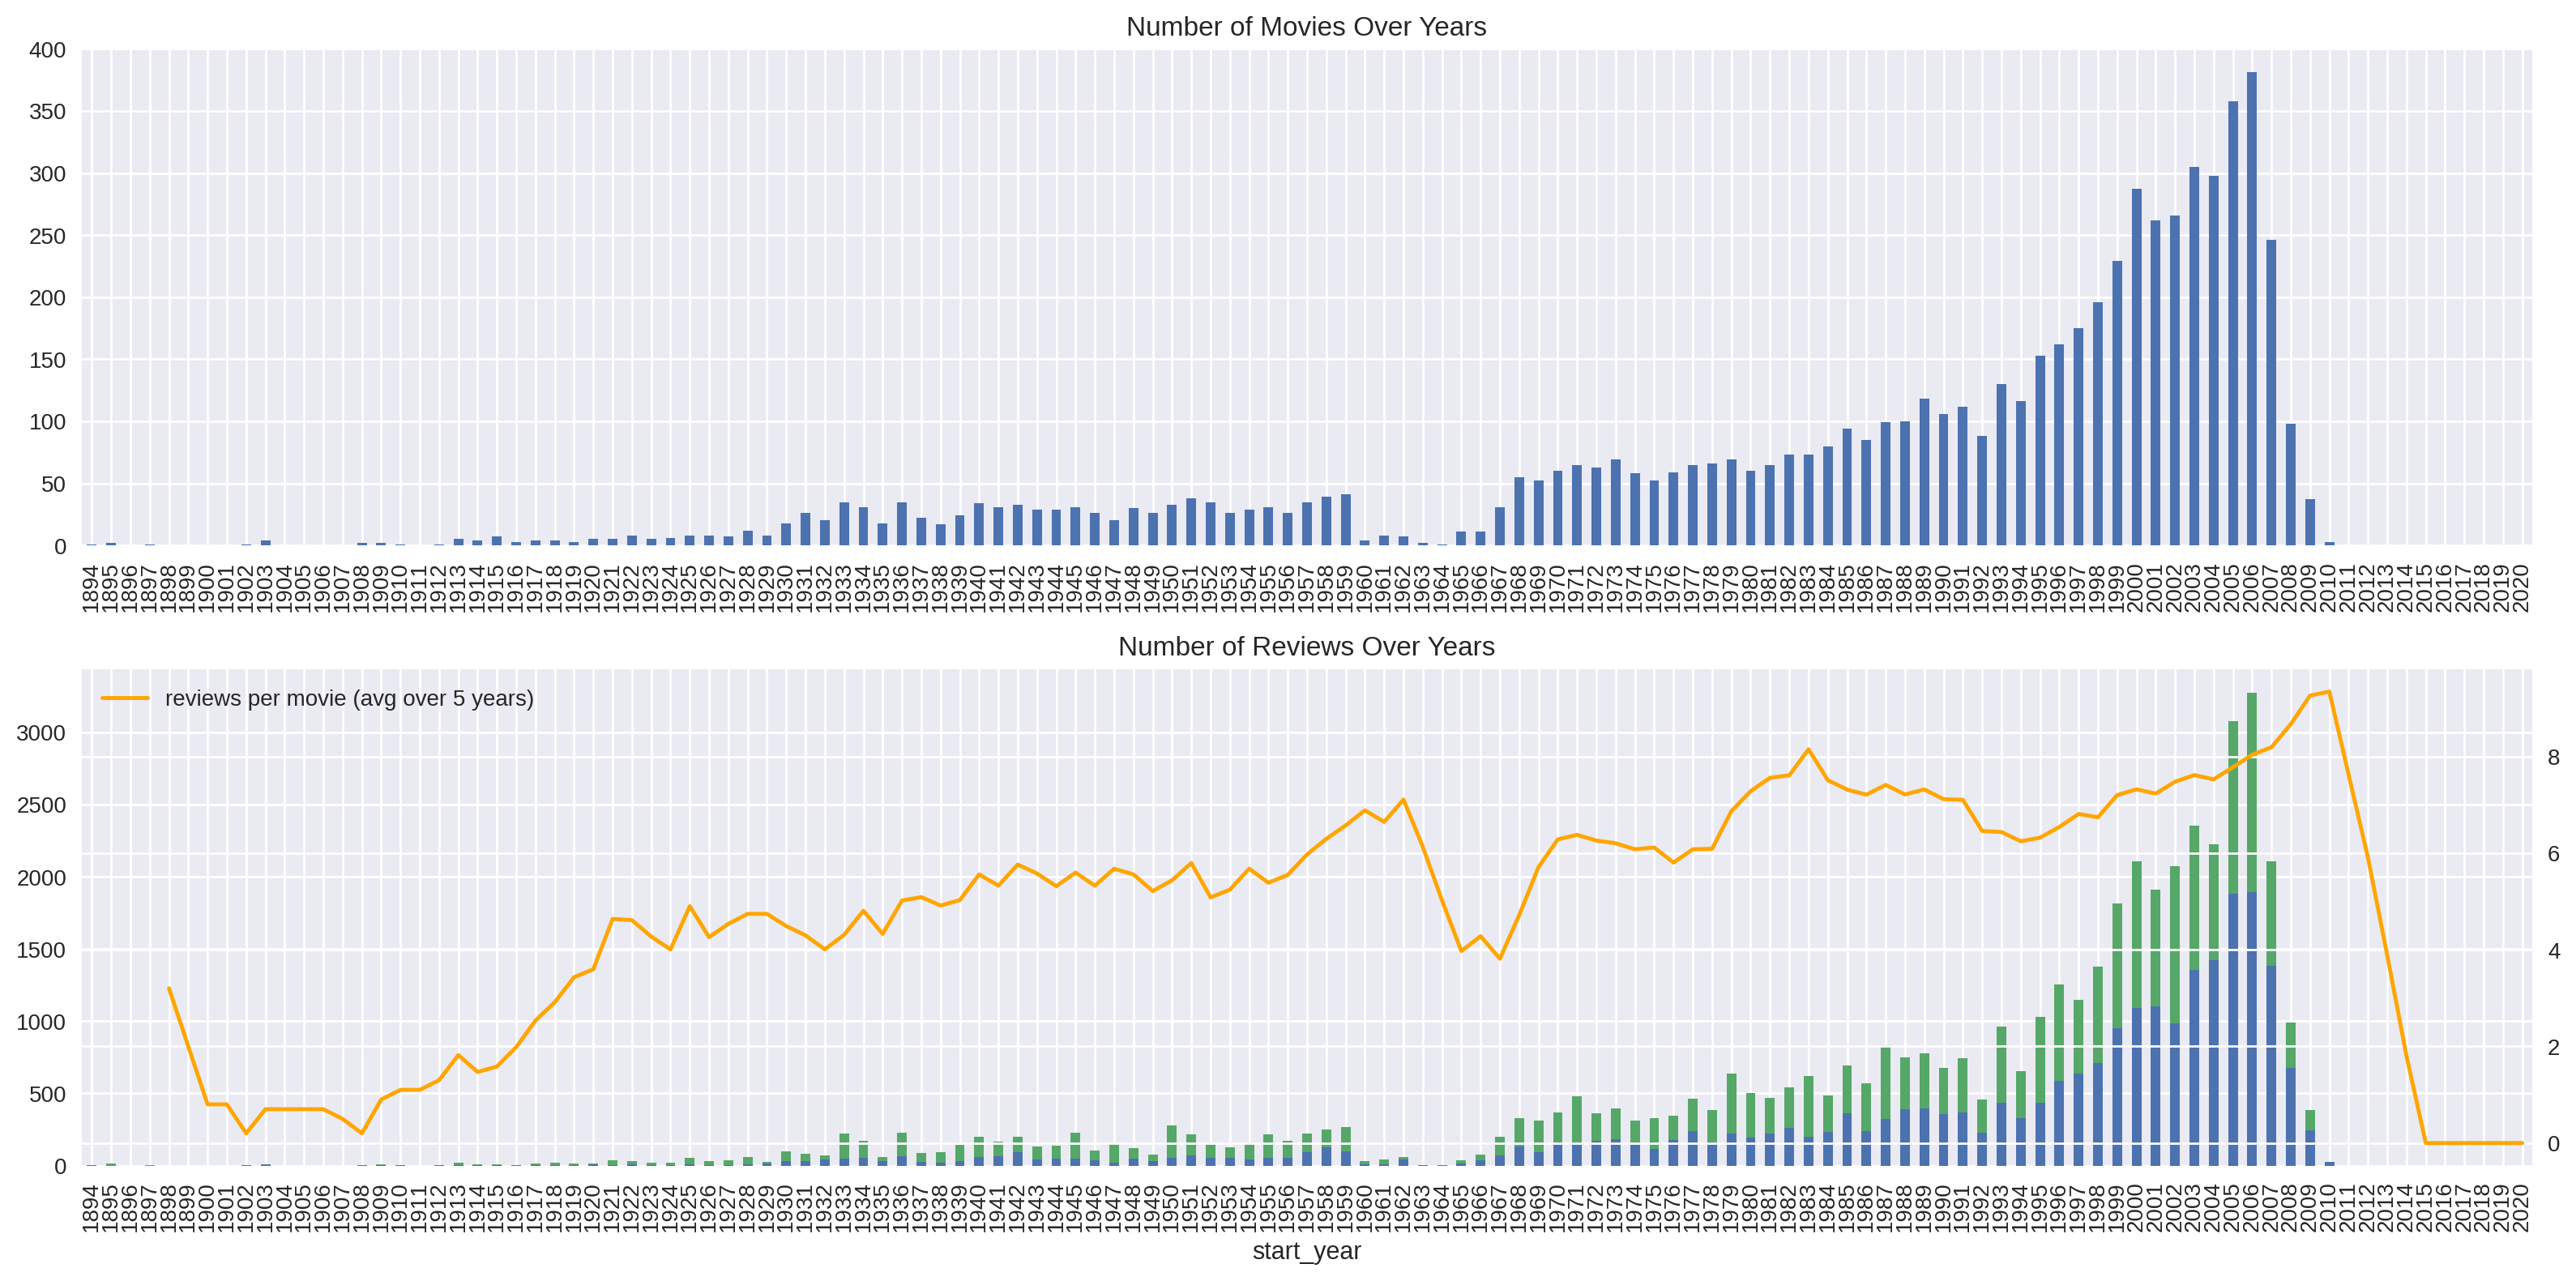

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

By looking at these charts we can see a pretty proportionate increasing trend of movies produced and reviews of movies. We can expect that as movies are released, they will also be reviewed, and with a decrease in movie releases, there will be a decrease in reviews that same year. Also there is a pretty high ratio of reviews per movie especially in the early 2000's decade. We can also conclude that films receive more positive reviews than negative. 

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

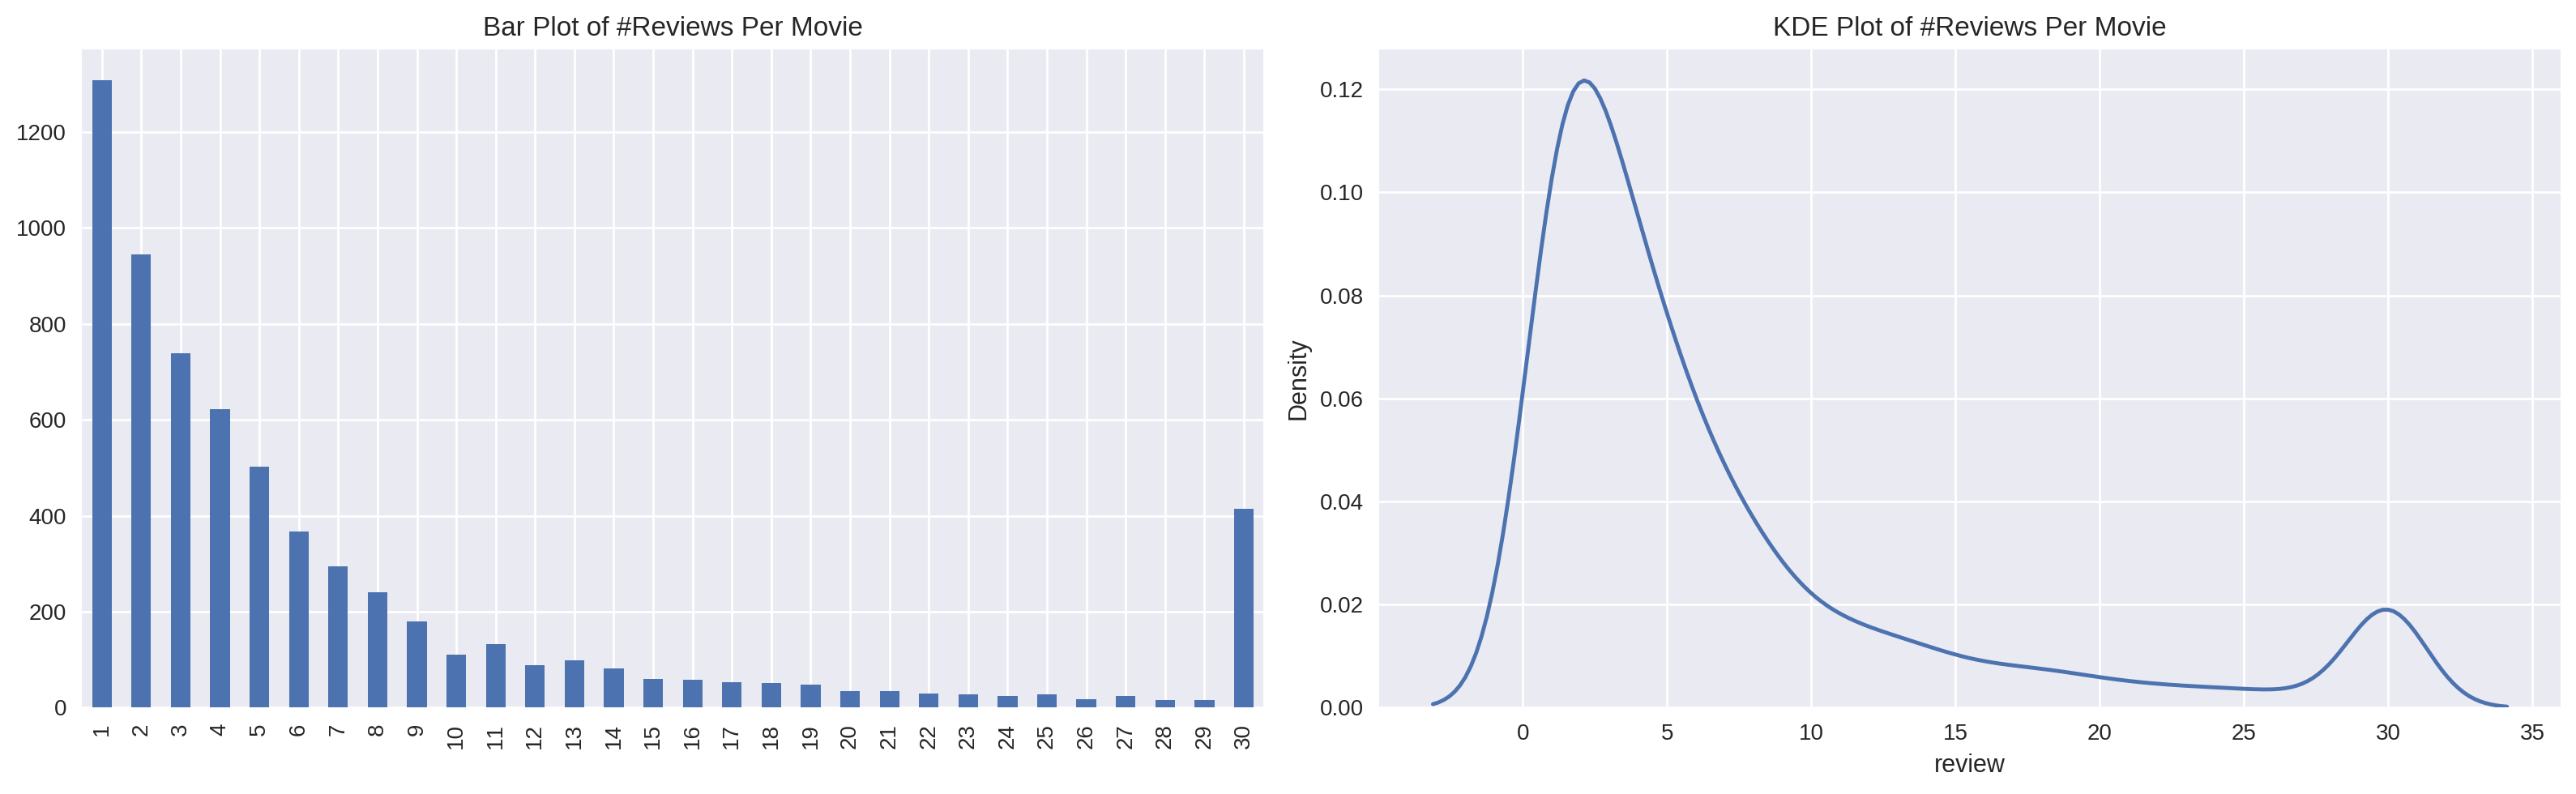

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

Here the bar plot gives us an exact count of reviews per movie where the KDE plot shows a smoother distribution of number of reviews per movie. We see a spike at exactly 30 reviews per movie. This may be for a few different reasons. Possibly the data is capped at 30 reviews per movie or the reviews are collected in batches of 30. Or it could be a data anomaly. More investigation of the data source would be needed to determine this outlier. 

In [13]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

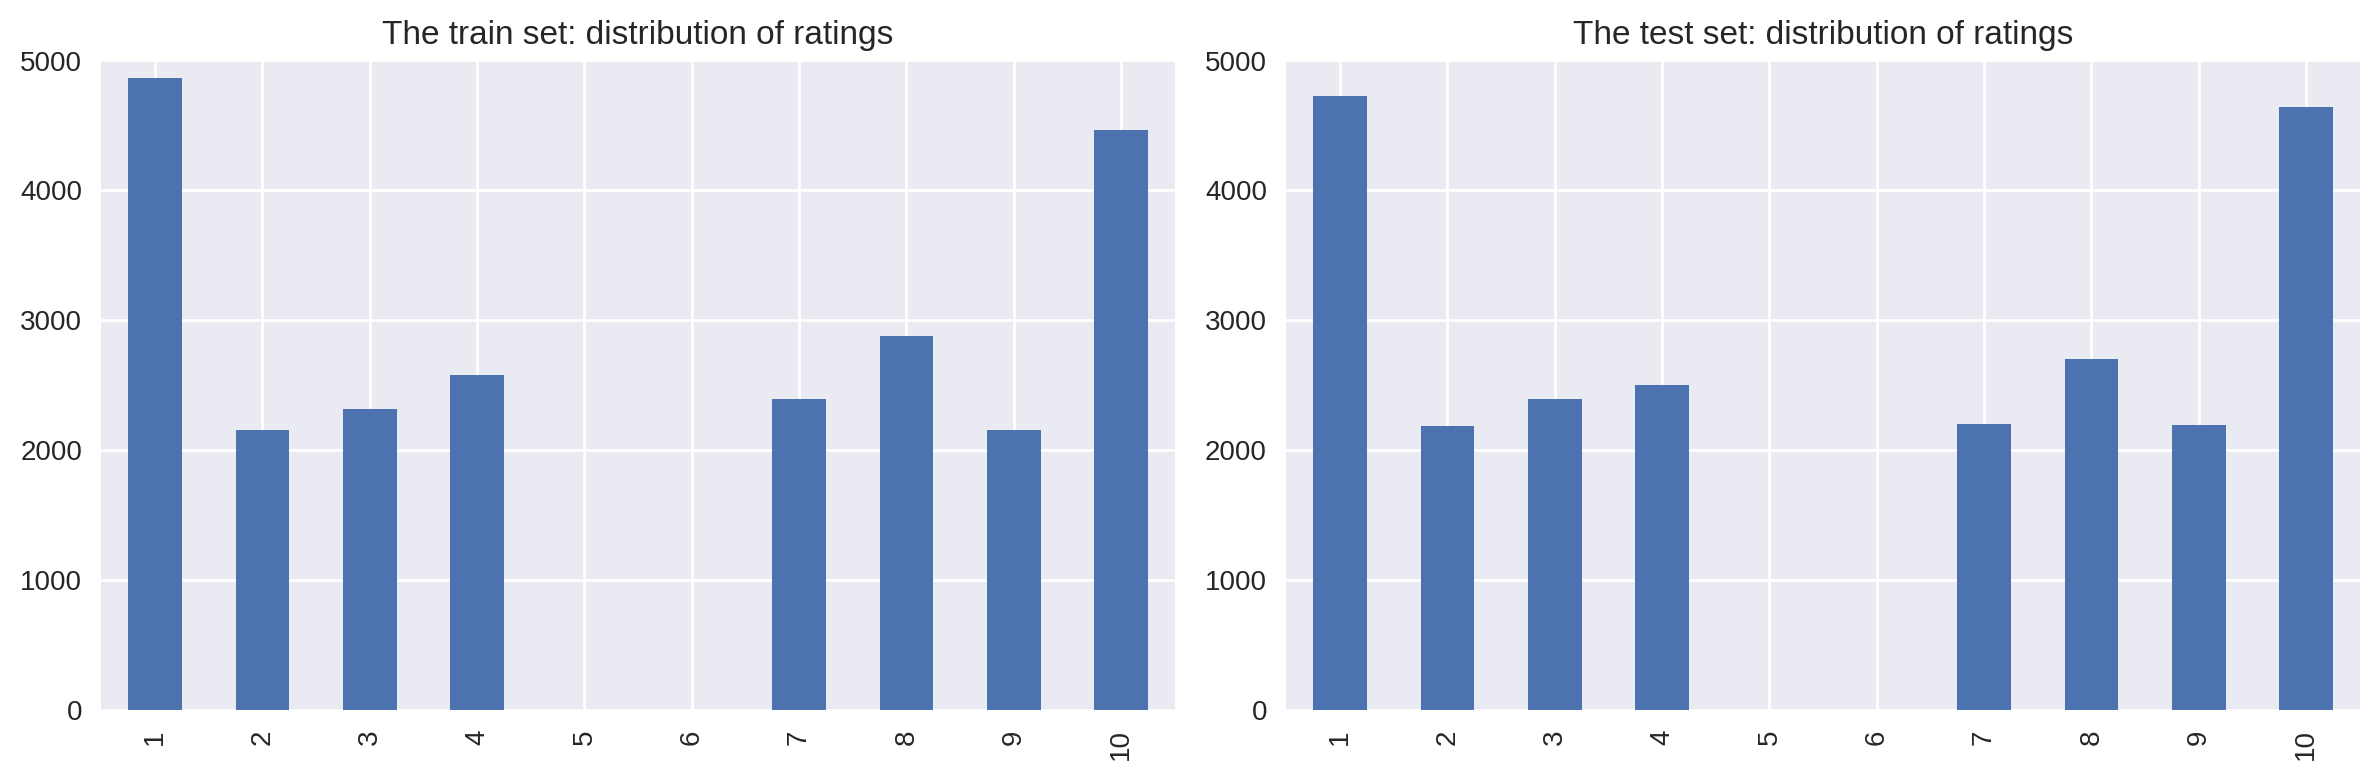

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Our distribution of positive and negative ratings in both our train and test set are pretty evenly distributed. This is good since it shows that our split was done well at maintaining the same class distribution in both sets. However, seeing that there are no ratings for 5 & 6 throughout our dataset suggests that our models will not learn to predict these ratings as there is nothing for them to learn from. 

In [15]:
df_ratings_5_6 = df_reviews[df_reviews['rating'].isin([5, 6])]
print(df_ratings_5_6)

Empty DataFrame
Columns: [tconst, title_type, primary_title, original_title, start_year, end_year, runtime_minutes, is_adult, genres, average_rating, votes, review, rating, sp, pos, ds_part, idx]
Index: []


Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


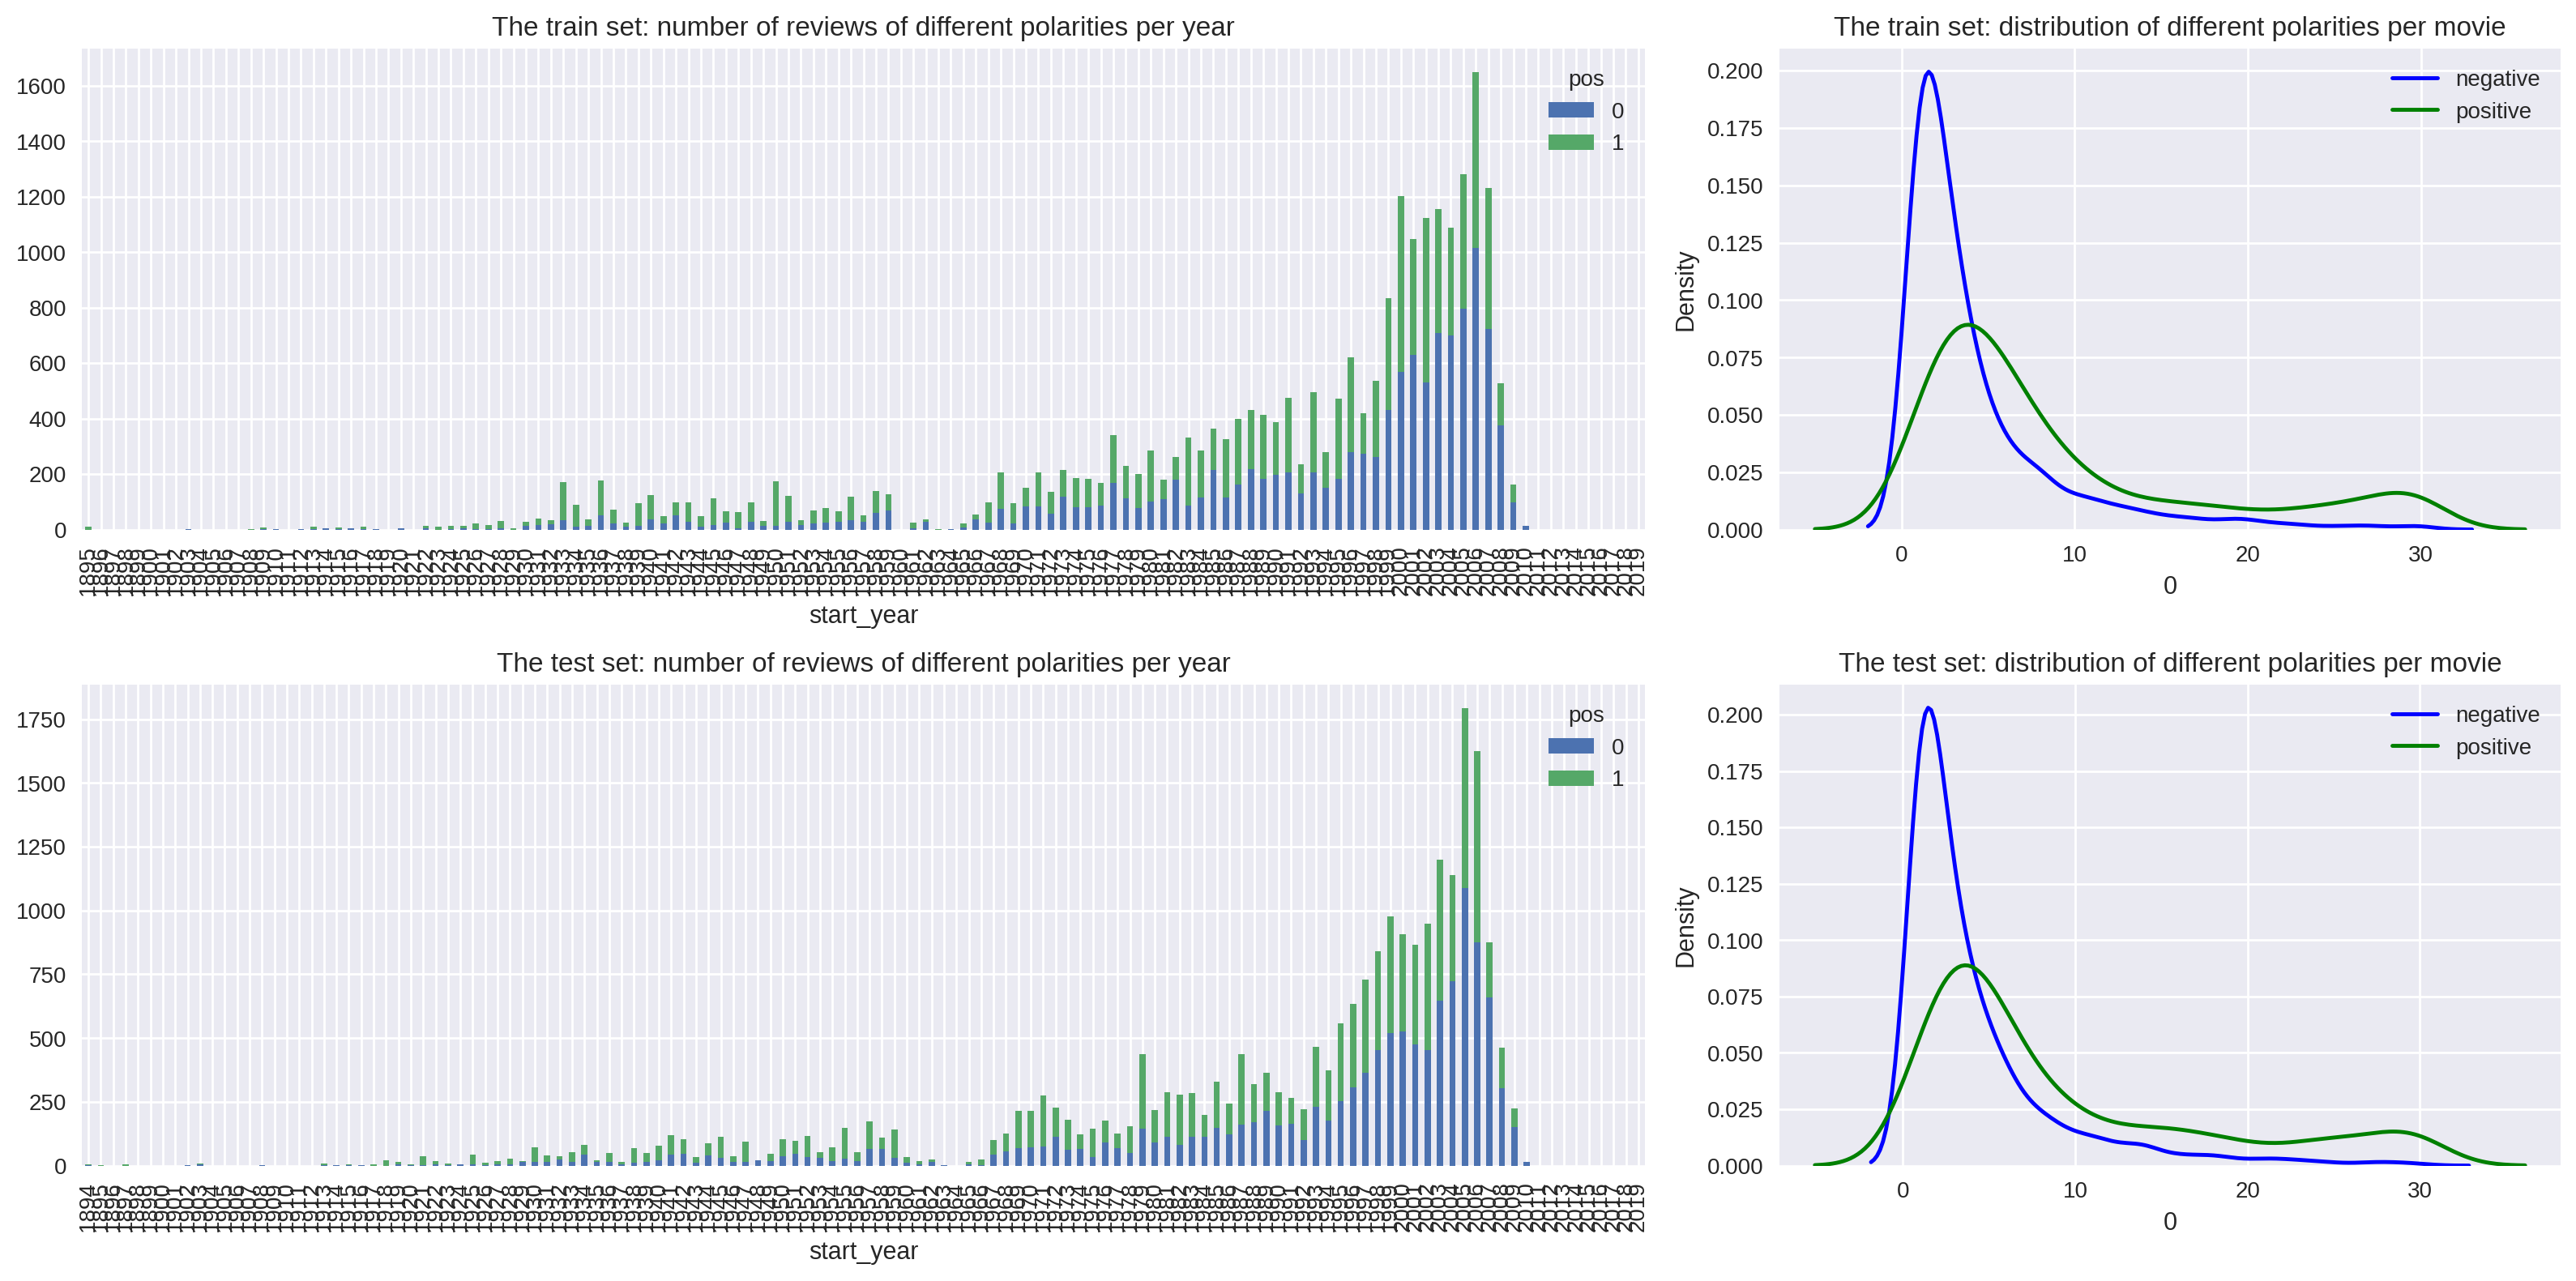

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

We can see between the train set and test set that the amount of positive and negative reviews over the years are pretty evenly distributed.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [1]:


def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'yellow'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [18]:
import re

In [19]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x))

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [20]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [21]:
from sklearn.dummy import DummyClassifier

In [22]:
model_0 = DummyClassifier(strategy='constant', constant=1)
model_0.fit(df_reviews_train, train_target)

DummyClassifier(constant=1, strategy='constant')

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50
None


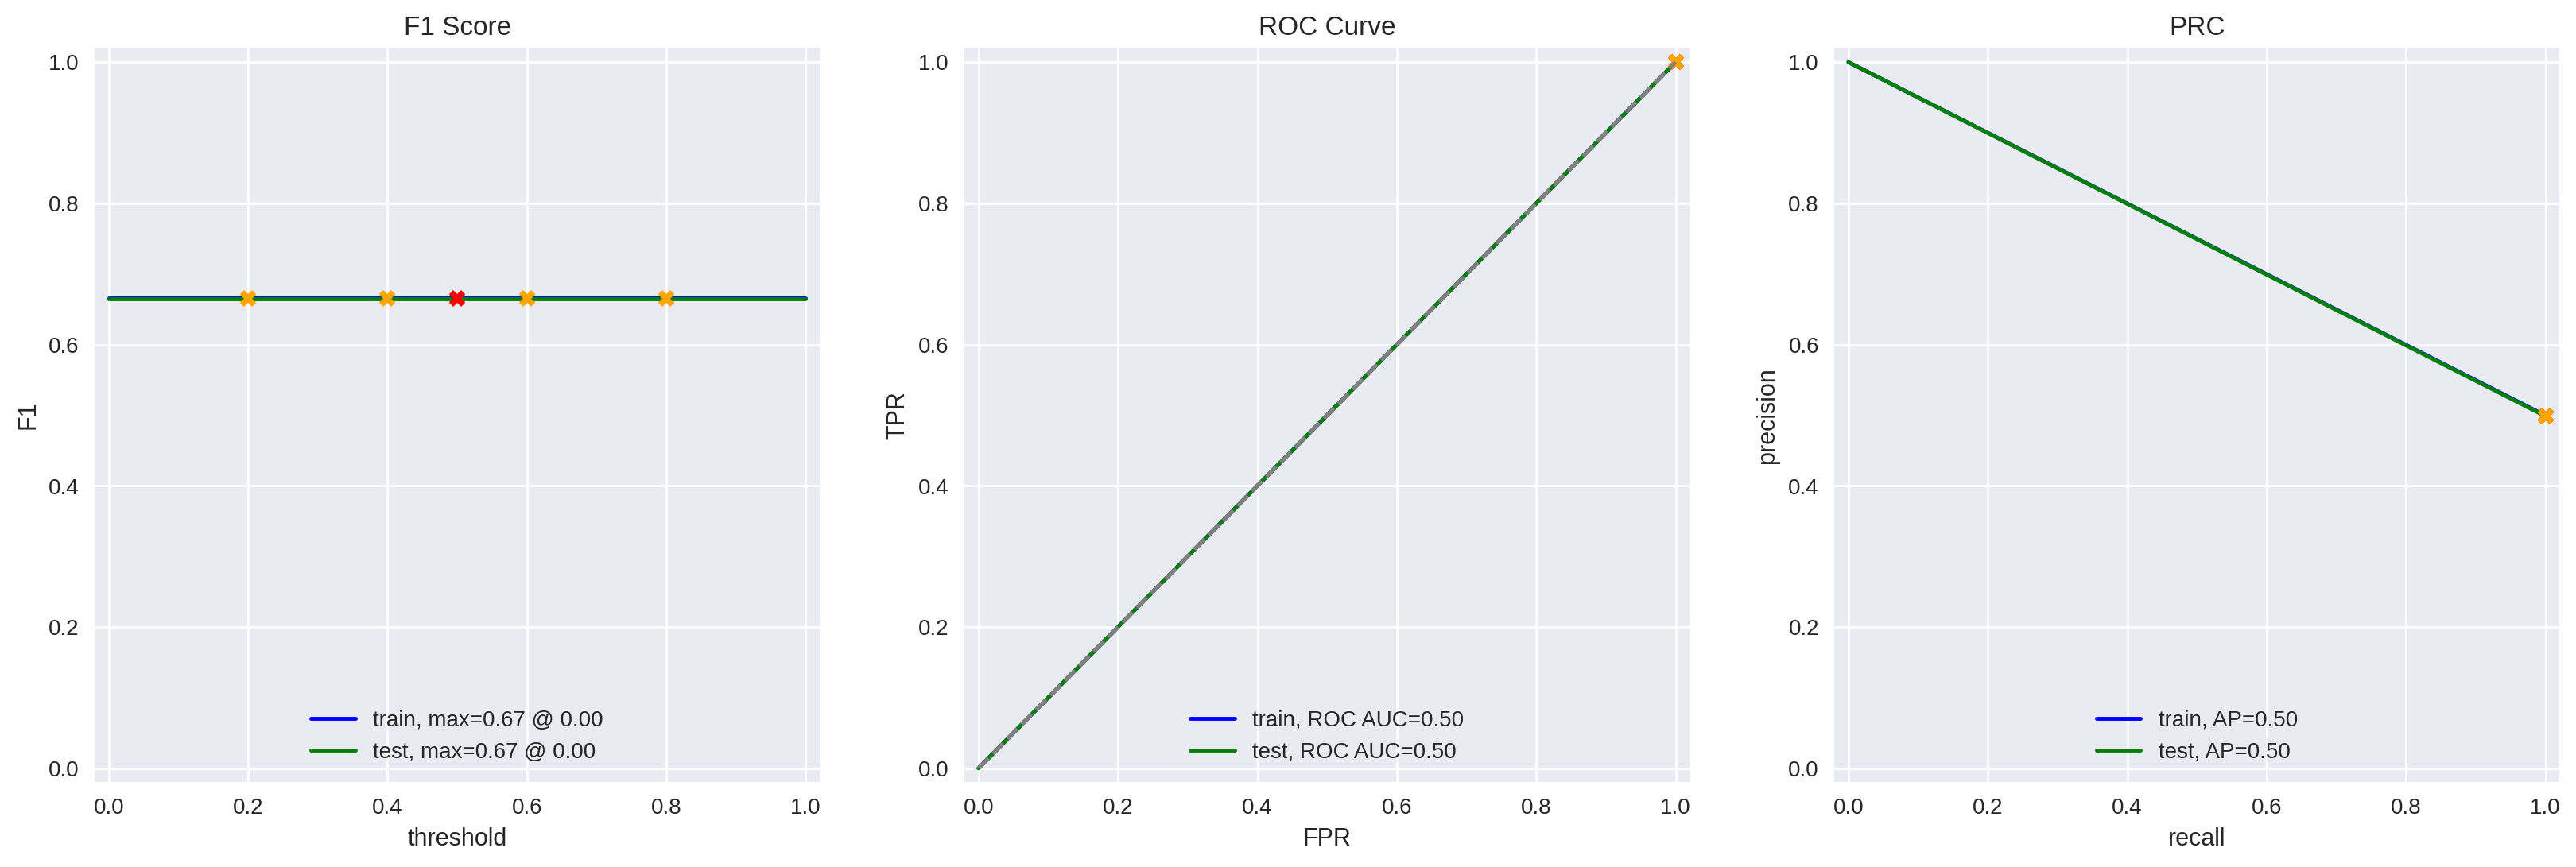

In [23]:
dummy_evaluation = evaluate_model(model_0, df_reviews_train, train_target, df_reviews_test, test_target)
print(dummy_evaluation)

Now we have our metrics for our baseline model, let's see how our actual ML models compare.

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5
Strategy: most_frequent
None
          train  test
Accuracy   0.49   0.5
F1         0.50   0.5
APS        0.50   0.5
ROC AUC    0.50   0.5
Strategy: stratified
None
          train  test
Accuracy    0.5  0.50
F1          0.5  0.49
APS         0.5  0.50
ROC AUC     0.5  0.50
Strategy: uniform
None
          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5
Strategy: prior
None


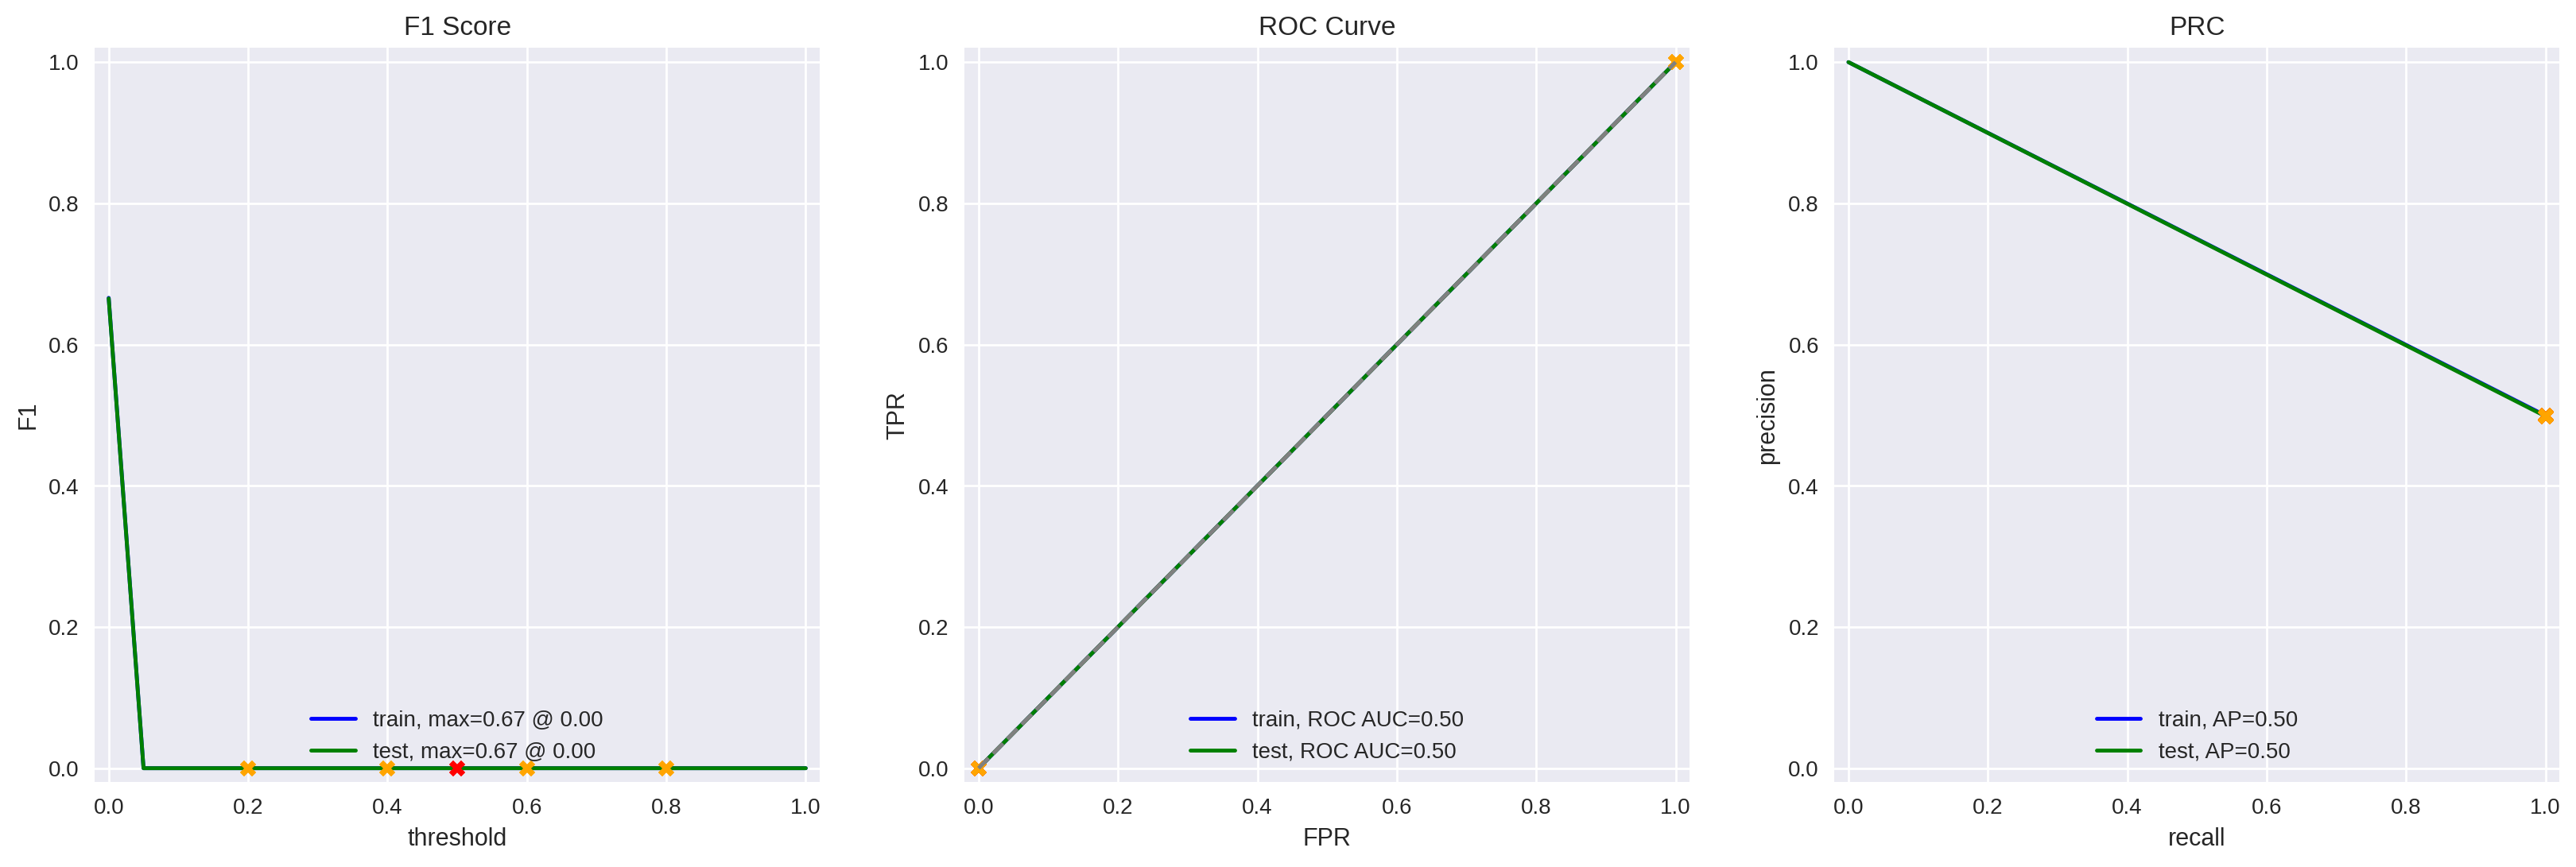

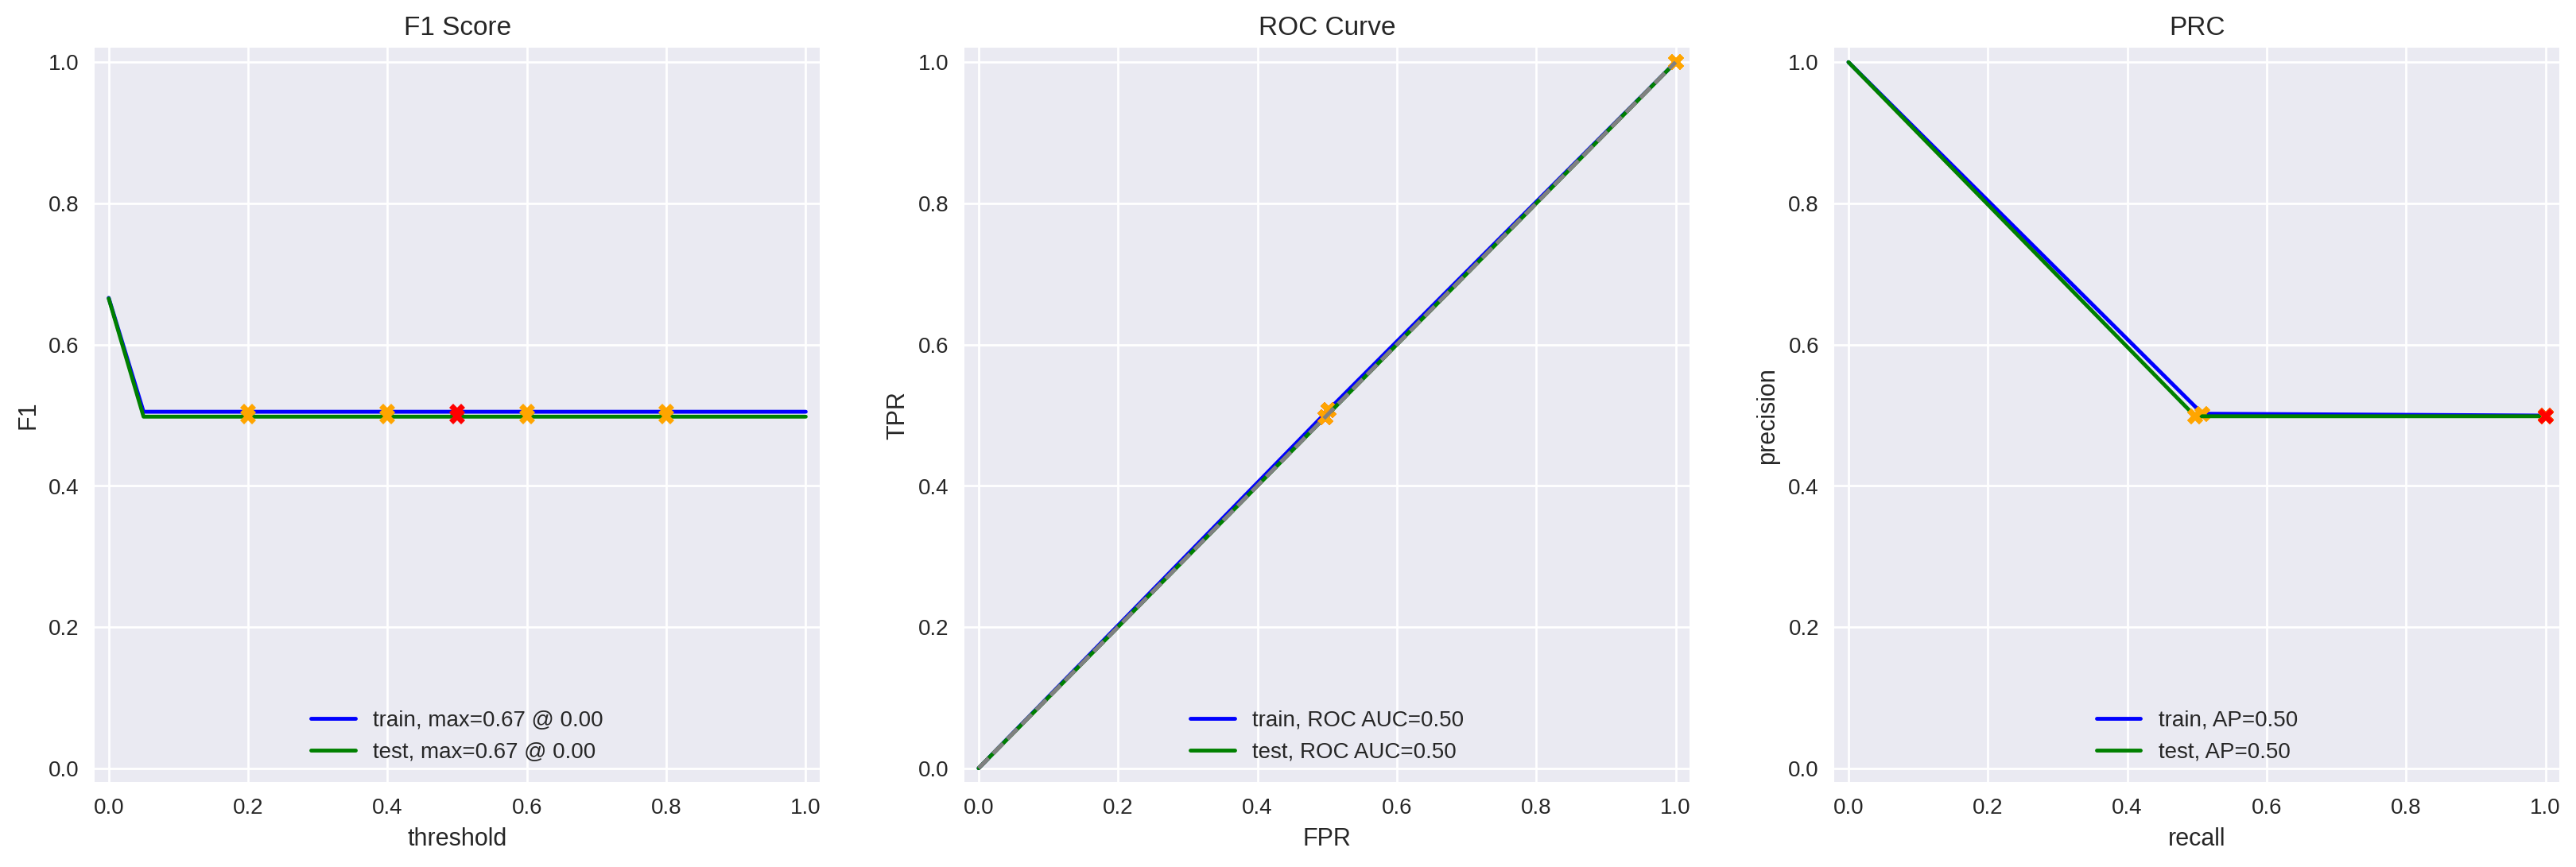

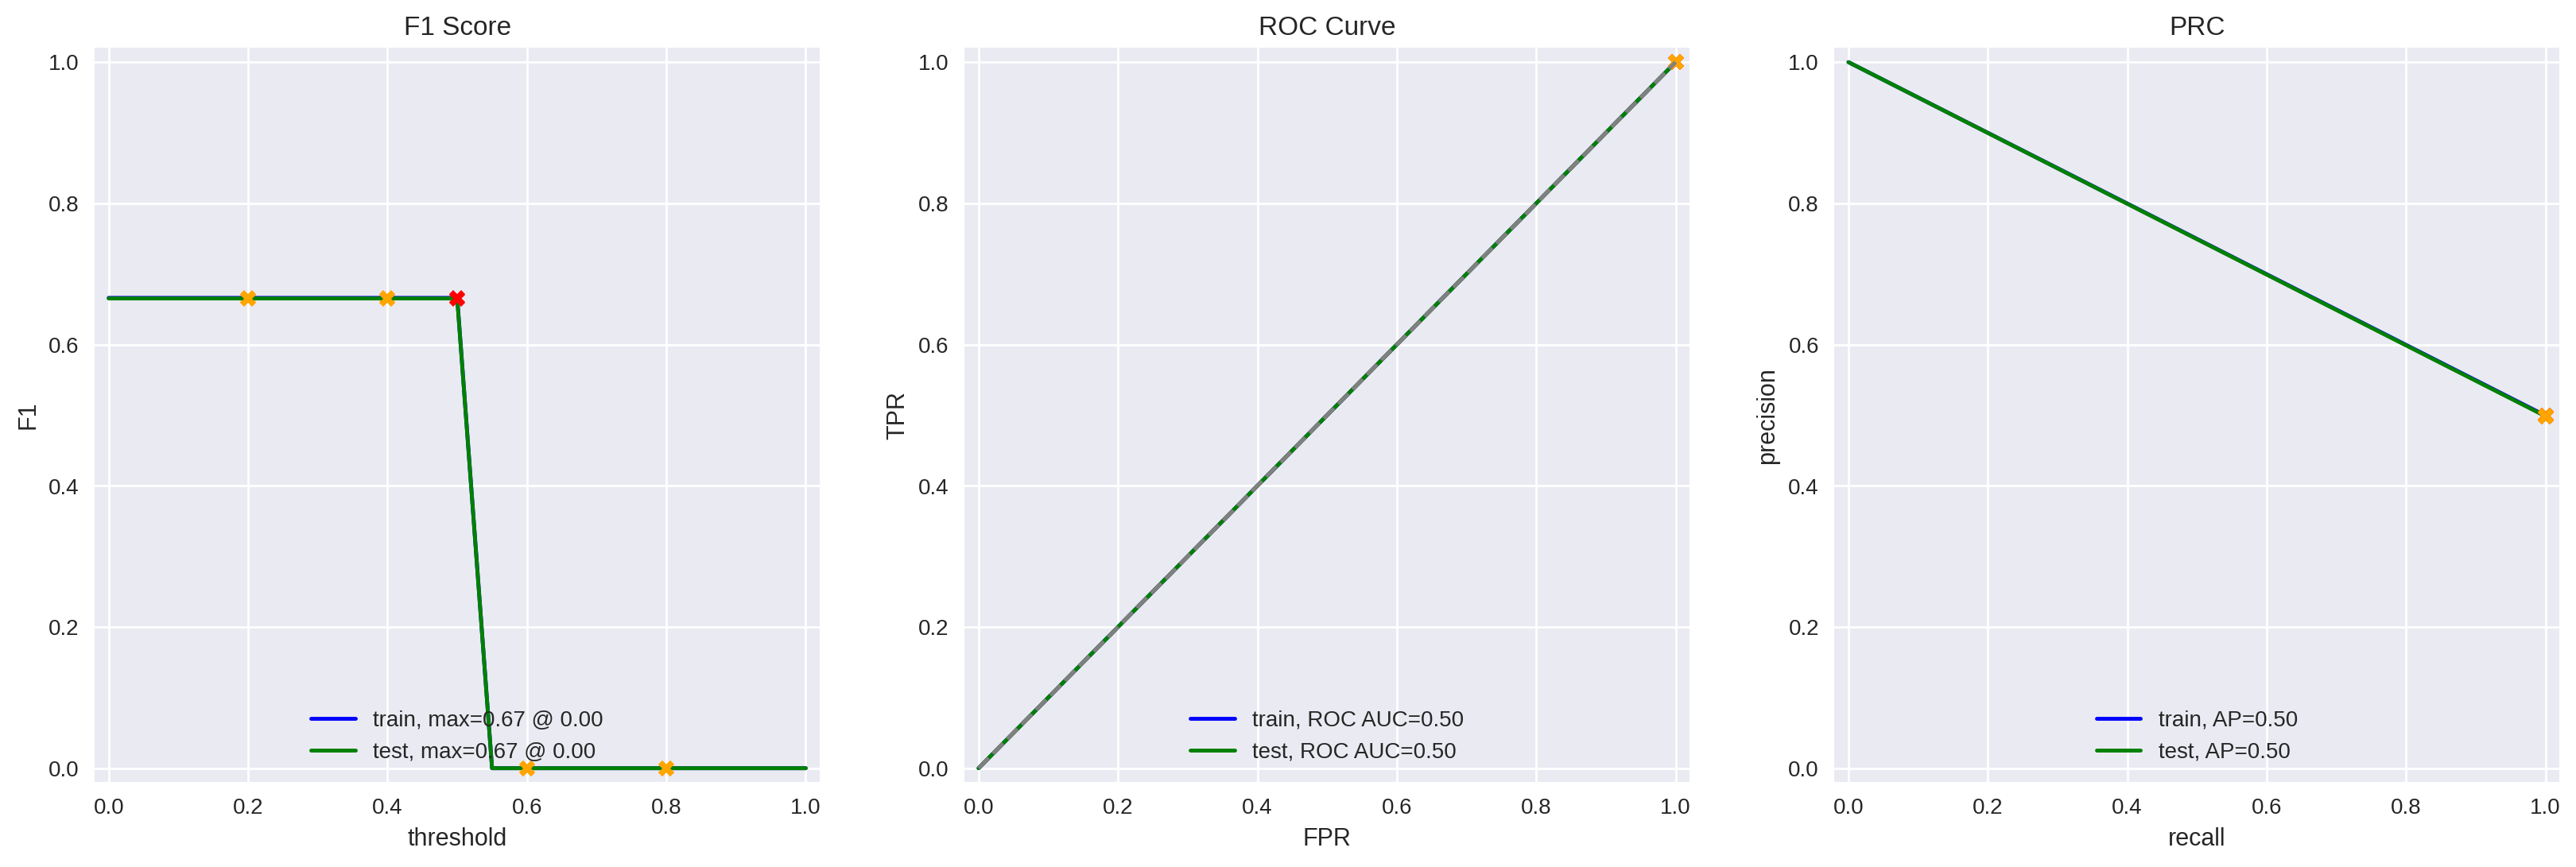

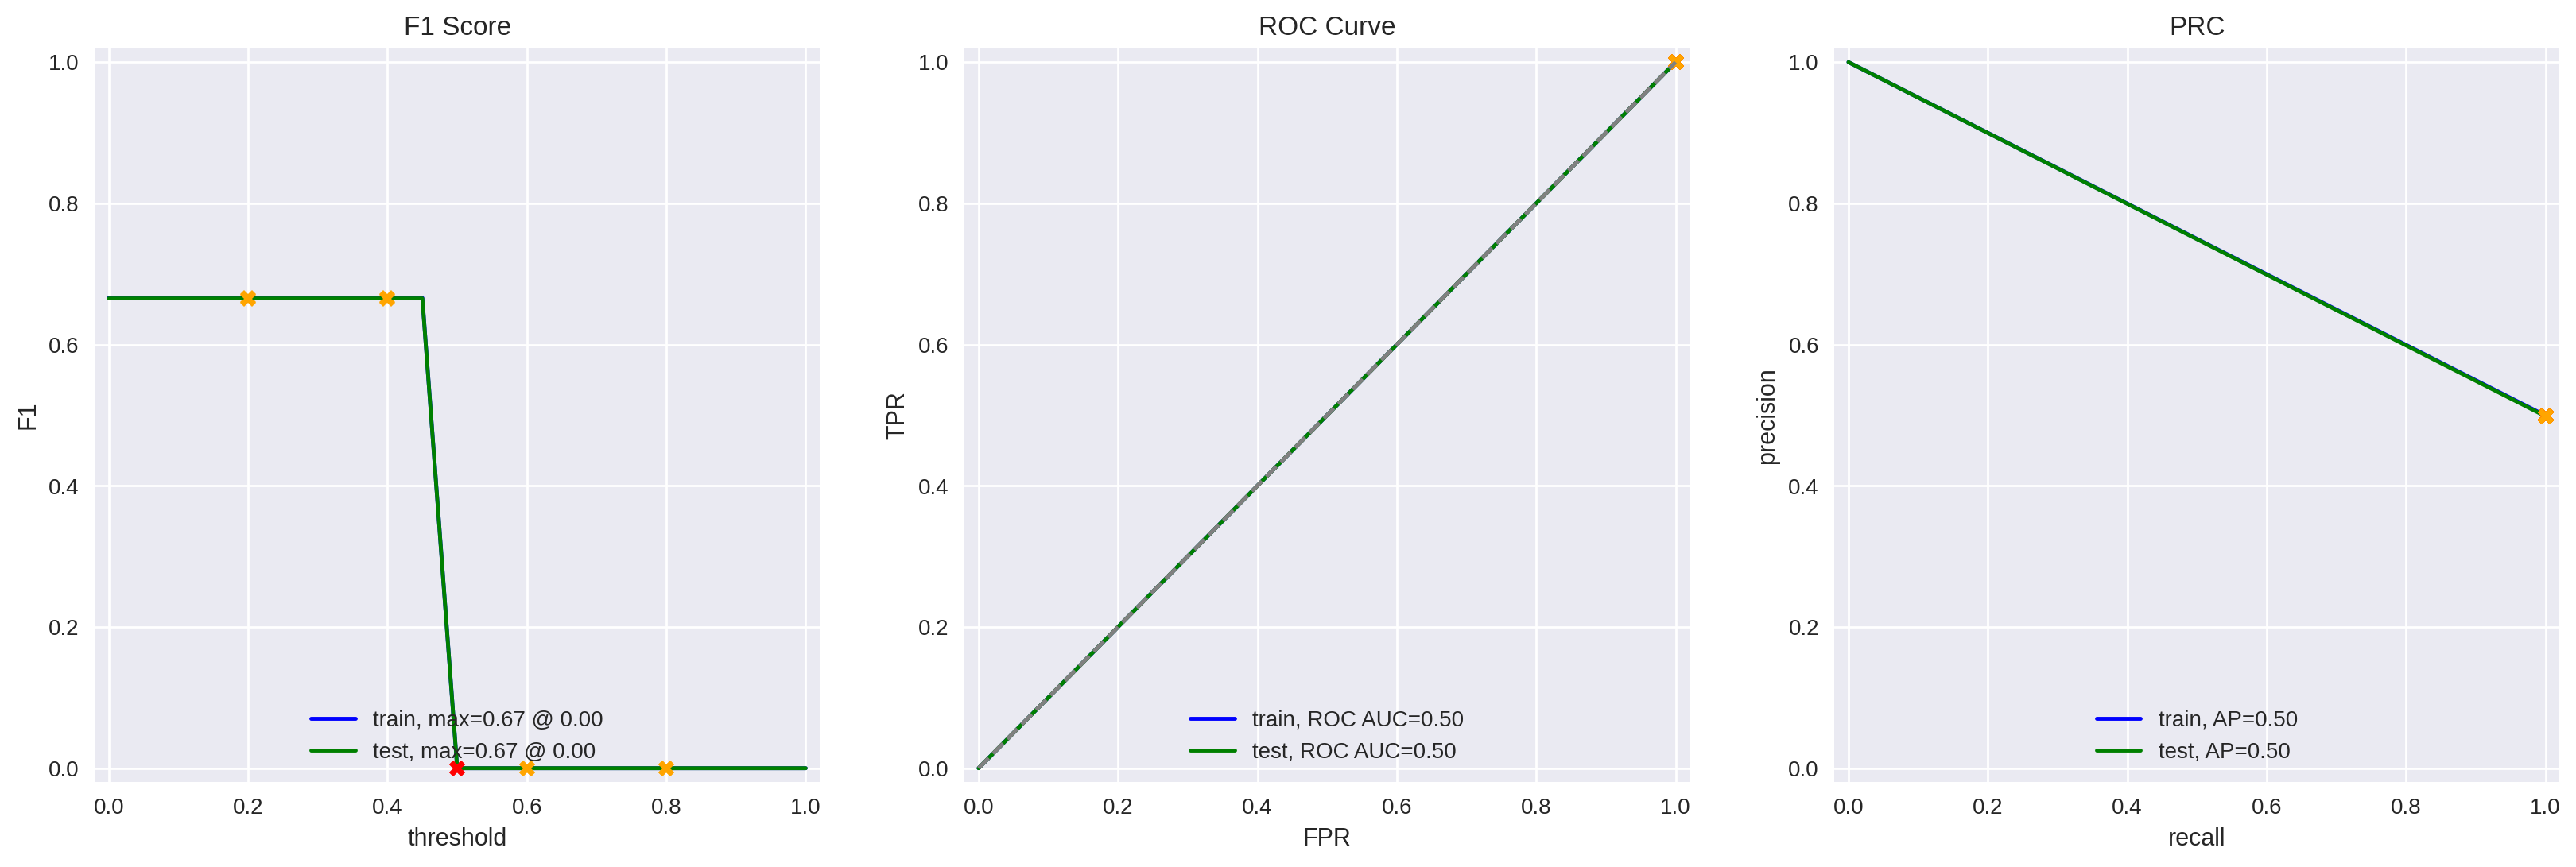

In [24]:
strategies = ['most_frequent', 'stratified', 'uniform', 'prior']

for strategy in strategies:
    model_dummy = DummyClassifier(strategy=strategy)
    model_dummy.fit(df_reviews_train, train_target)
    dummy_eval = evaluate_model(model_dummy, df_reviews_train, train_target, df_reviews_test, test_target)
    print(f"Strategy: {strategy}")
    print(dummy_eval)

Using different strategies with our dummy classifier models we get evaluation metrics of about 0.50 across the board, no matter the strategy used. These are about as good as guessing if the reviews are positive or negative. We are confident our models will perform much better than chance. 

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [25]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [26]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

train_features_1 = df_reviews_train['review_norm'].apply(preprocess)
test_features_1 = df_reviews_test['review_norm'].apply(preprocess)


tfidf_lr = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
lr_model = LogisticRegression(random_state=42)

model_1 = Pipeline([
    ('tfidf_lr', tfidf_lr),
    ('lr', lr_model)
])


model_1.fit(train_features_1, train_target)

Pipeline(steps=[('tfidf_lr',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('lr', LogisticRegression(random_state=42))])

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


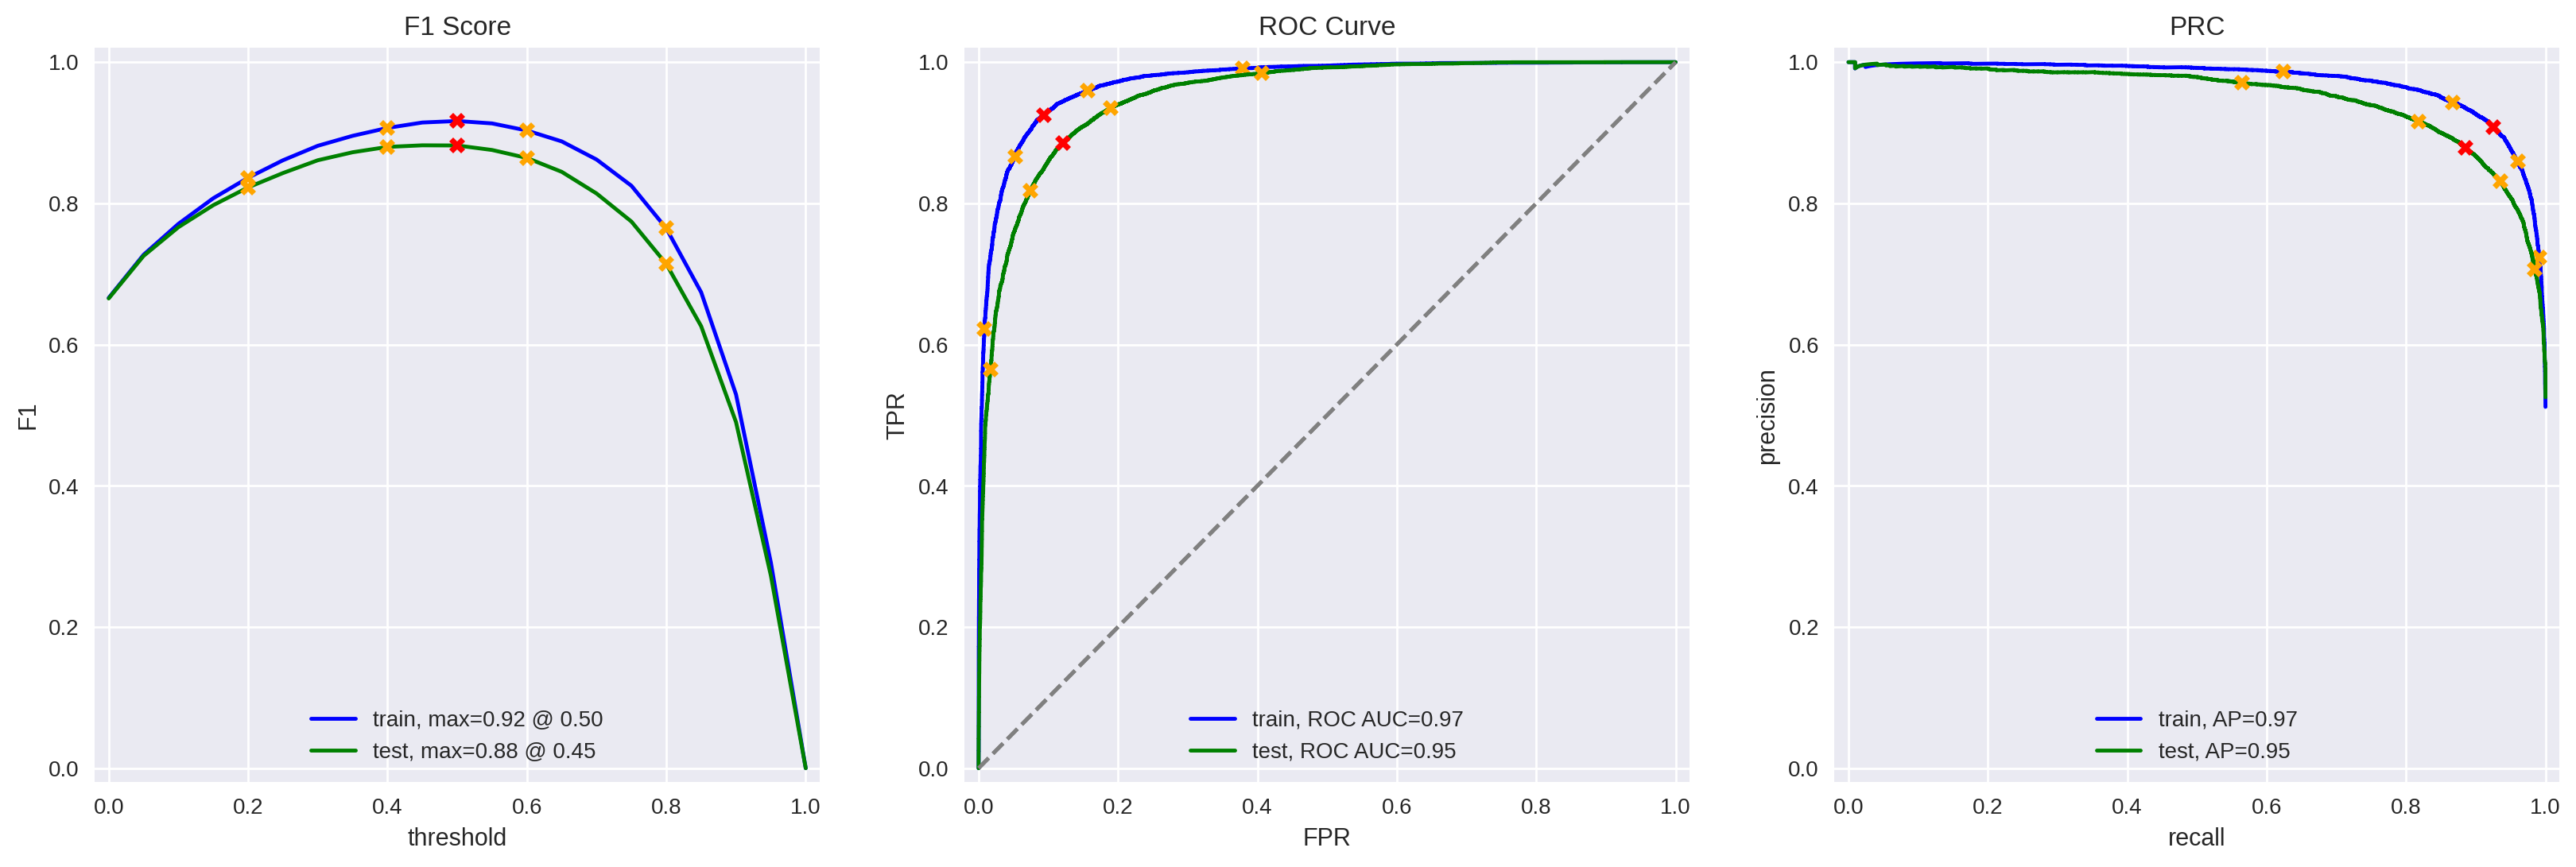

In [27]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

Our results show that our model 1 is performing quite well. 

### Model 2 - NLTK, TF-IDF and XGBoost

In [28]:
from xgboost import XGBClassifier

In [29]:
tfidf = TfidfVectorizer(max_features=5000)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

model_2 = Pipeline([
    ('tfidf', tfidf),
    ('xgb', xgb)
])


model_2.fit(train_features_1, train_target)


Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='mlogloss', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                  

          train  test
Accuracy   0.94  0.85
F1         0.95  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


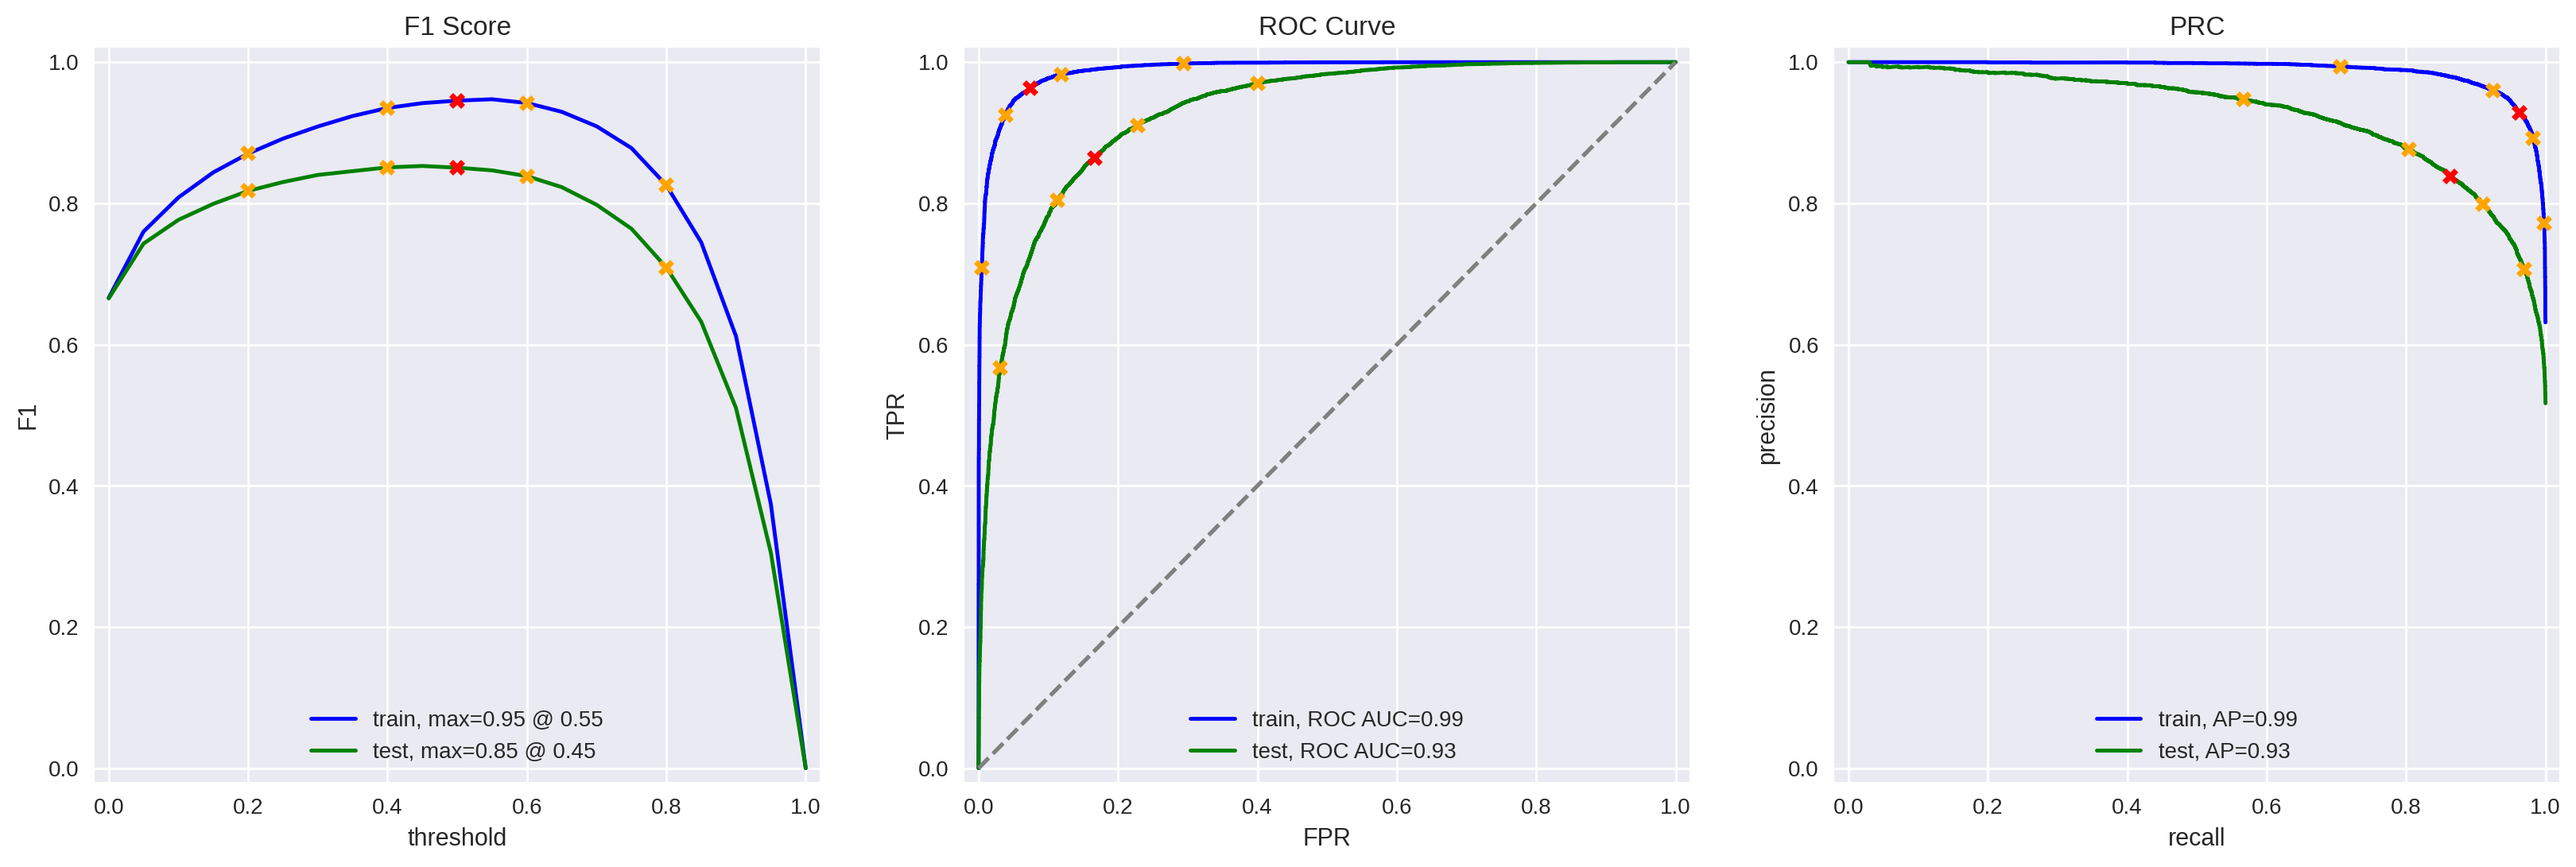

In [30]:
evaluate_model(model_2, train_features_1, train_target, test_features_1, test_target)

Model 2 performs very well on the training dataset but struggles a bit more on unseen data. The test set scores are still high but not as comparable to the training set scores. Also, with training set scores of .99, I have to wonder if the model is overfitting. 

### Model 3 - spaCy, TF-IDF and LR

In [31]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [32]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc if not  token.is_stop]
    
    return ' '.join(tokens)

In [33]:
df_reviews_train['processed_text_3'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['processed_text_3'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [34]:
tfidf = TfidfVectorizer(max_features=5000)
lr_model = LogisticRegression(random_state=42)

model_3 = Pipeline([
    ('tfidf', tfidf),
    ('lr', lr_model)
])

# Fit the pipeline
model_3.fit(df_reviews_train['processed_text_3'], train_target)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('lr', LogisticRegression(random_state=42))])

          train  test
Accuracy   0.91  0.87
F1         0.91  0.87
APS        0.97  0.94
ROC AUC    0.97  0.95


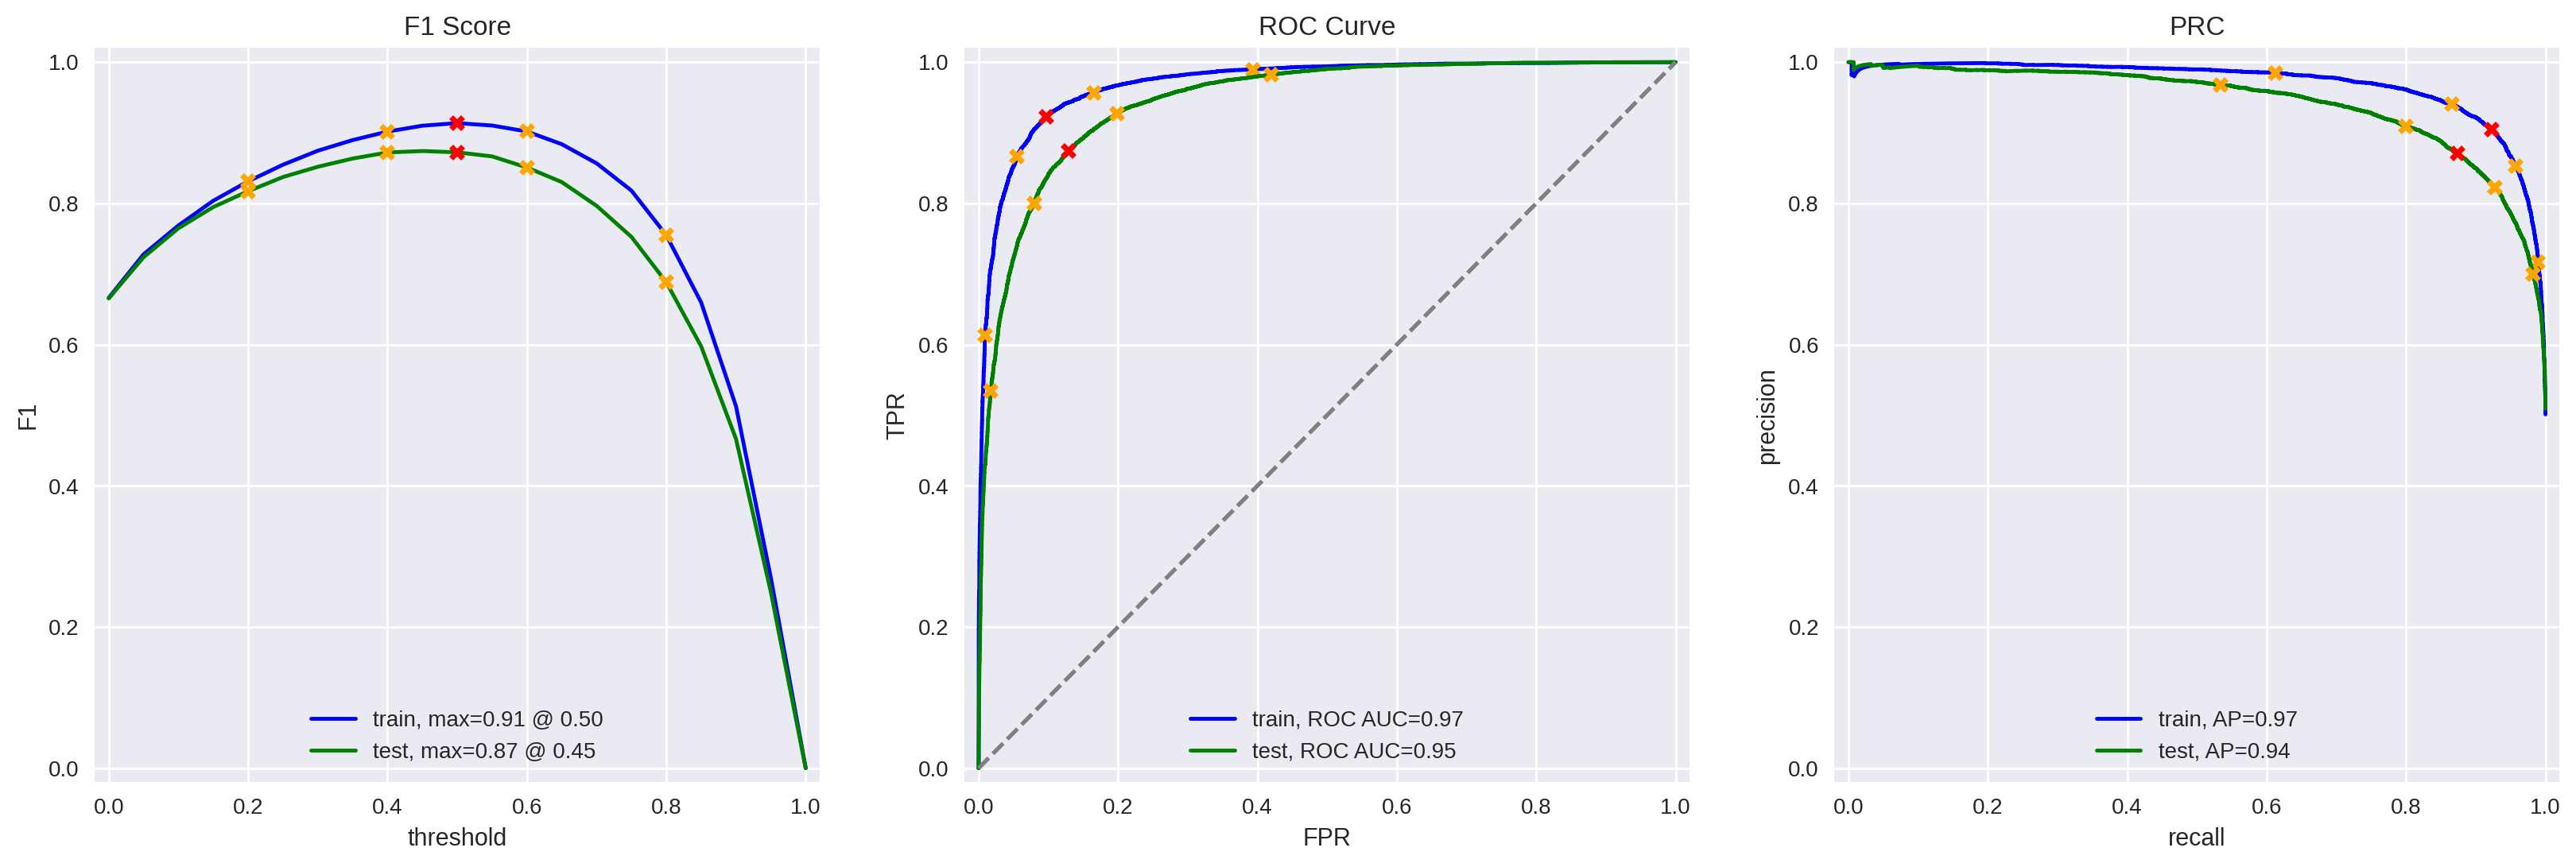

In [35]:
evaluate_model(model_3, df_reviews_train['processed_text_3'], train_target, df_reviews_test['processed_text_3'], test_target)

Model 3 performs pretty well on both trained data and the test set (unseen data), similar to model 1, giving us both high and very comparable evaluation metrics. This seems to be a strong and balanced model.

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [36]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [37]:
lgbm_model = lgb.LGBMClassifier(random_state=42)

model_4 = Pipeline([
    ('tfidf', tfidf),
    ('lgbm', lgbm_model)
])

model_4.fit(df_reviews_train['processed_text_3'], train_target)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('lgbm', LGBMClassifier(random_state=42))])

          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


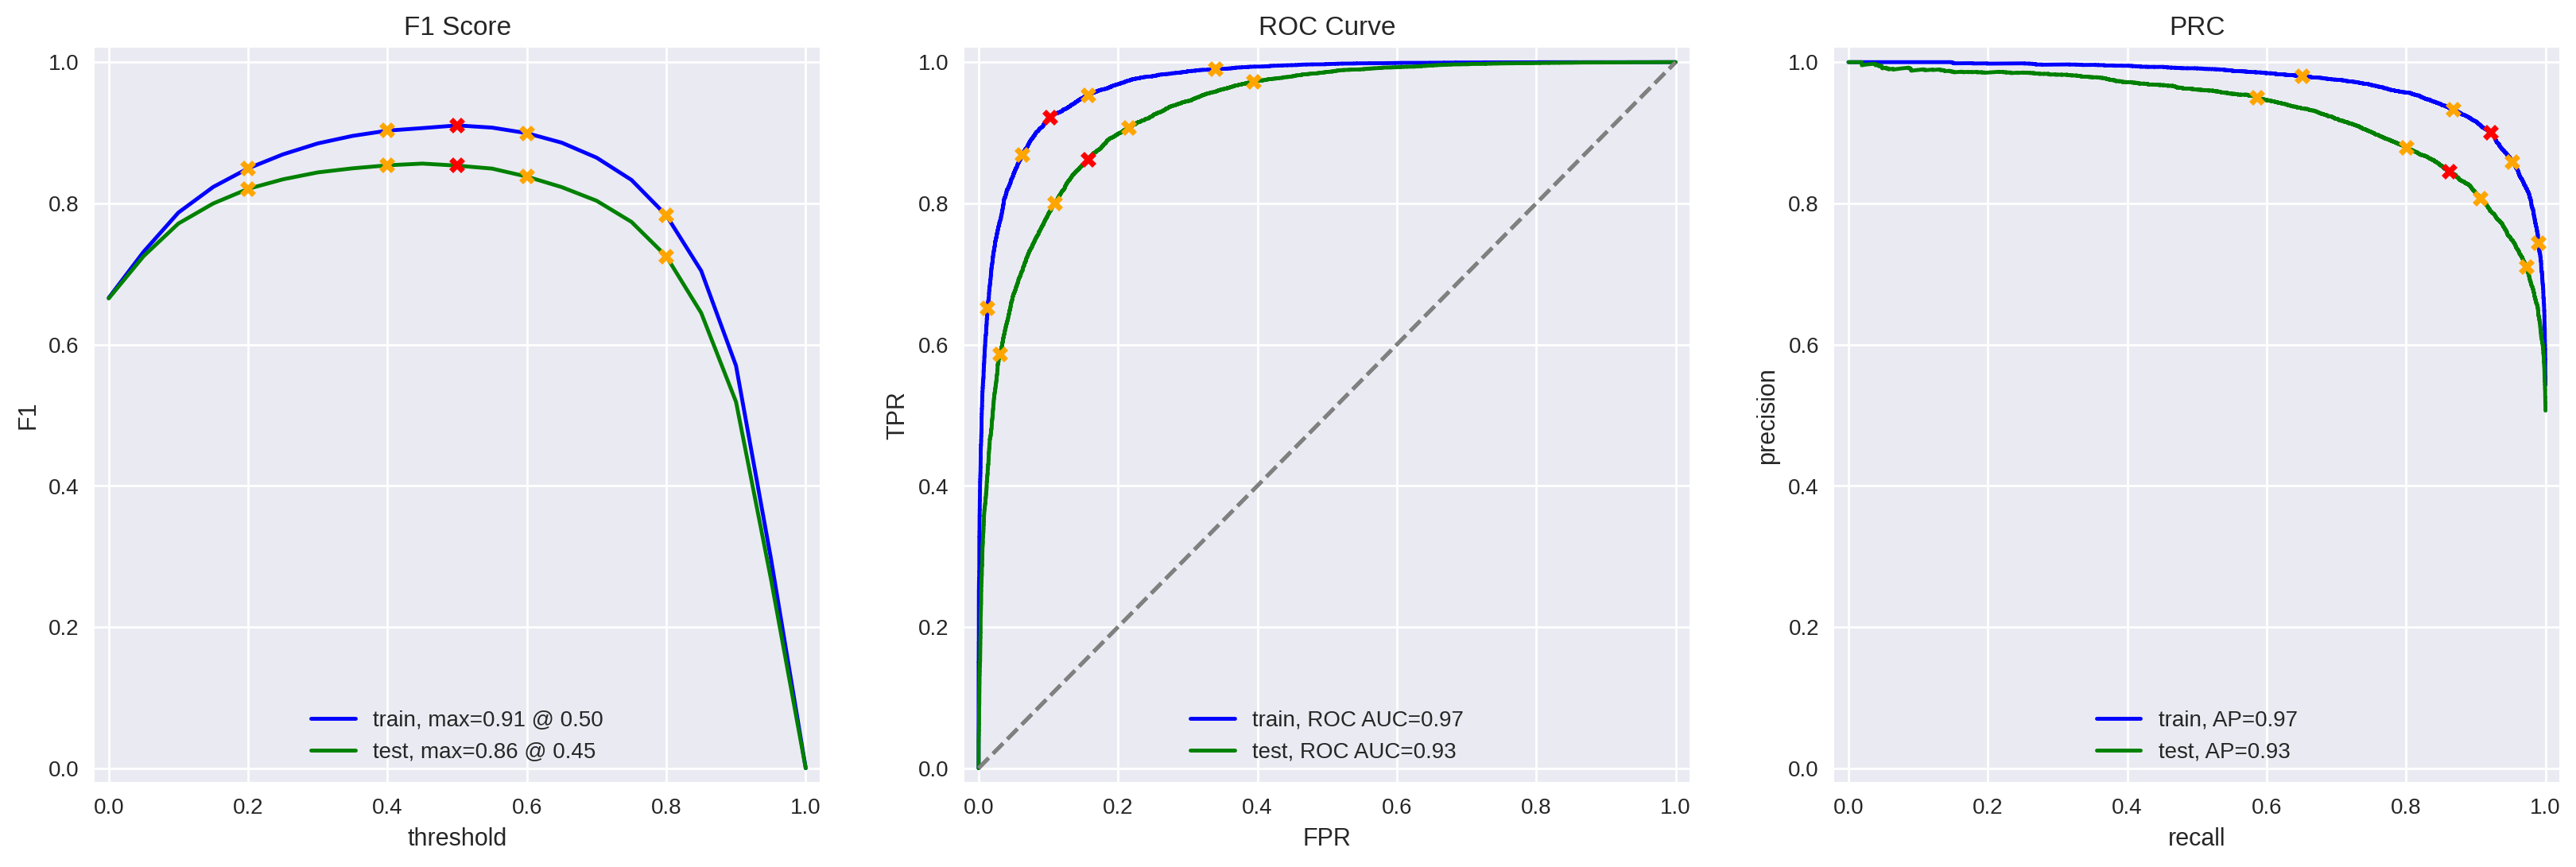

In [38]:
evaluate_model(model_4, df_reviews_train['processed_text_3'], train_target, df_reviews_test['processed_text_3'], test_target)

Again, we get high evaluation metrics indicating a strong model but the difference between the train scores and test scores show the model struggles more on unseen data. Since we have better models with closer evaluation metrics, we expect they'll perform better on upcoming reviews.

### Model 5 - spaCy, TF-IDF and XGBoost

In [39]:
model_5 = Pipeline([
    ('tfidf', tfidf),
    ('xgb', xgb)
])

model_5.fit(df_reviews_train['processed_text_3'], train_target)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='mlogloss', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, predictor='auto',
                               random_state=42, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                  

          train  test
Accuracy   0.94  0.85
F1         0.94  0.85
APS        0.99  0.92
ROC AUC    0.99  0.92


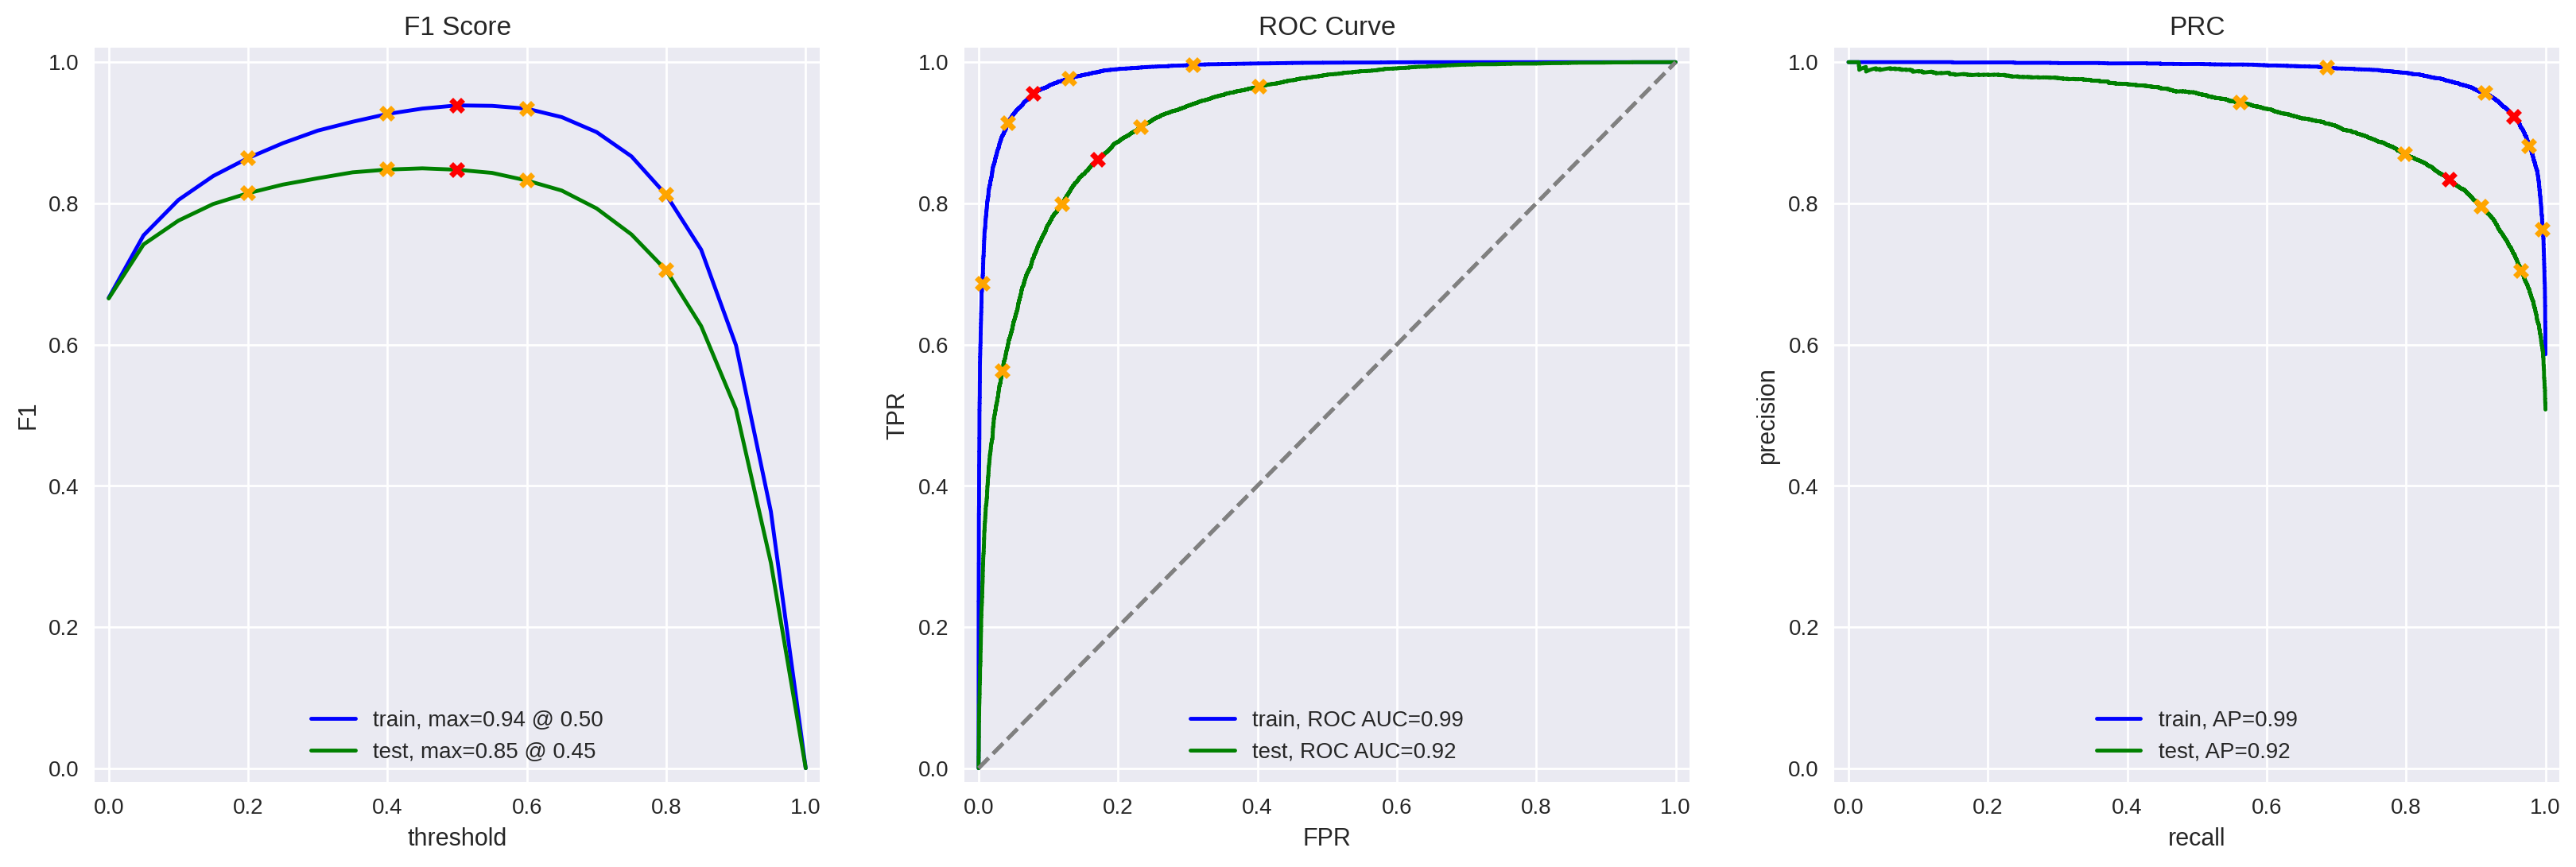

In [40]:
evaluate_model(model_5, df_reviews_train['processed_text_3'], train_target, df_reviews_test['processed_text_3'], test_target)

Model 5 performs similarly to model 4 but does even better on the training data than model 4. Again though, it doesn't perform as well on unseen data but is still a strong model. However, the average precision score (APS) and Roc Auc score are close to 1 on the training set, suggesting the model is highly confident in it's predictions of positive classes with few false negatives. To me, this could mean the model is overfitting to the training data, therefore, not as trustworthy. 

## My Reviews

In [41]:


my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x))

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Model 1

In [42]:
texts = my_reviews['review_norm']
tfidf_vectorizer_1 = model_1.named_steps['tfidf_lr']
texts_transformed = tfidf_vectorizer_1.transform(texts)
predictor = model_1.named_steps['lr']


my_reviews_pred_prob = predictor.predict_proba(texts_transformed)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.41:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.21:  i didnt expect the reboot to be so good writers really cared about the source material
0.44:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.94:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 2

In [43]:
texts = my_reviews['review_norm']
tfidf_vectorizer_2 = model_2.named_steps['tfidf']
texts_transformed = tfidf_vectorizer_2.transform(texts)
predictor = model_2.named_steps['xgb']


my_reviews_pred_prob = predictor.predict_proba(texts_transformed)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.73:  i did not simply like it not my kind of movie
0.43:  well i was bored and felt asleep in the middle of the movie
0.66:  i was really fascinated with the movie
0.56:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.59:  i didnt expect the reboot to be so good writers really cared about the source material
0.66:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.56:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.66:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 3

In [44]:
texts = my_reviews['review_norm']
tfidf_vectorizer_3 = model_3.named_steps['tfidf']
texts_transformed = tfidf_vectorizer_3.transform(texts)
predictor = model_3.named_steps['lr']

my_reviews_pred_prob = my_reviews_pred_prob = predictor.predict_proba(texts_transformed)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.06:  i did not simply like it not my kind of movie
0.05:  well i was bored and felt asleep in the middle of the movie
0.44:  i was really fascinated with the movie
0.48:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.47:  i didnt expect the reboot to be so good writers really cared about the source material
0.68:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.97:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 4

In [45]:
texts = my_reviews['review_norm']
tfidf_vectorizer_4 = model_4.named_steps['tfidf']
texts_transformed = tfidf_vectorizer_4.transform(texts)
predictor = model_4.named_steps['lgbm']

my_reviews_pred_prob = predictor.predict_proba(texts_transformed)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.44:  i did not simply like it not my kind of movie
0.32:  well i was bored and felt asleep in the middle of the movie
0.67:  i was really fascinated with the movie
0.67:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.67:  i didnt expect the reboot to be so good writers really cared about the source material
0.71:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.23:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.86:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 5

In [46]:
texts = my_reviews['review_norm']
tfidf_vectorizer_5 = model_5.named_steps['tfidf']
texts_transformed = tfidf_vectorizer_5.transform(texts)
predictor = model_5.named_steps['xgb']

my_reviews_pred_prob = predictor.predict_proba(texts_transformed)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.44:  i did not simply like it not my kind of movie
0.20:  well i was bored and felt asleep in the middle of the movie
0.64:  i was really fascinated with the movie
0.64:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.62:  i didnt expect the reboot to be so good writers really cared about the source material
0.73:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.40:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.85:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


## Conclusions

**Model 1** predicts lower probabilities for negative reviews (e.g.,0.94, 0.05) and higher probability for clearly positive reviews (0.88). This NLTK, TF-IDF and LR model is the most conservative with predicting probabilities and may miss some subtleties to clearly distinguish between positive and negative reviews. Overall, still a good model.

**Model 2** probabilities are all near 0.50, showing it struggles with prediction certainty. This one we will not be using.

**Model 3** shows high probabilities for both positive and negative reviews. It shows high variance and is capable of detecting both strong positive and negative reviews with good differentiation.

**Models 4 and 5** are similar in that they both provide confident predictions with model 4 being slightly more aggressive than model 5. However, because a clearly positive and clearly negative review were both given the same probability (0.67 and 0.64), it shows that these models aren't as good at understanding sentiment nuances.

In my opinion, **models 1 & 3**, Linear Regression, are our best models at predicting positive and negative reviews. Let's compare these two model's further: 

**Positive Review (Expected):** "I was really fascinated with the movie" <-- Model 1: 0.41 <-- and --> Model 2: 0.44 <br>
**Negative Review (Expected):** "Even the actors looked really old and disinterested and they got paid to be in the movie" <-- Model 1: 0.11 <-- and --> Model 2: 0.48 <br>

These probabilities indicate that Model 1 might not be confident in classifying a review as positive (0.41 under 0.50) but has a strong confidence that a review is negative (0.11 way below 0.5).
Model 3's prediction for a positive review is 0.44, below 0.5, indicating less confidence in predicting the review is positive. 
Model 3's prediction for a negative review is 0.48, slightly below 0.5, suggesting some confusion between positive and negative.

With our goal of distinguishing negative reviews, **Model 1** is a preferable option. Model 3 provides more confidence in it's predictions. Further tuning would be needed to see if we can combine the strengths of both models.